Magdalena Bernat, GGSN 2025, gr 1

In [ ]:
# !pip install keras_tuner

In [65]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import joblib
import pickle
import keras_tuner as kt
import tensorflow.keras.backend as K
import tensorflow as tf
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, log_loss, classification_report, auc
from xgboost import XGBClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau, ModelCheckpoint


# Zbiór danych

W projekcie korzystać będziemy ze zbioru Adult Income Dataset pochodzącego z platformy Kaggle. Dataset zawiera dane demograficzne oraz zawodowe osób, których dochody roczne klasyfikowane są do jednej z dwóch kategorii: ≤50K lub >50K. Dane obejmują cechy takie jak wiek, wykształcenie, stan cywilny, zawód czy liczba przepracowanych godzin tygodniowo.

In [4]:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "adult.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "wenruliu/adult-income-dataset",
  file_path,
)

#podstawowe informacje o zbiorze
print(df.head())
print(df["income"].value_counts())  #0: <=50K, 1: >50K

<ipython-input-4-2a15e734858b>:7: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


100%|██████████| 652k/652k [00:00<00:00, 32.4MB/s]

Extracting zip of adult.csv...


   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country incom

Jak widać, rozkład danych w zbiorze jest nierównomierny - około 75% próbek należy do klasy <=50K, co oznacza, że większość osób w zbiorze zarabia mniej niż 50 000 USD rocznie. Z kolei tylko 25% przypadków dotyczy osób zarabiających powyżej tej kwoty. Takie rozróżnienie może prowadzić do pewnych wyzwań w modelowaniu, ponieważ modele mogą mieć tendencję do przewidywania klasy dominującej

# Przygotowanie danych do treningu modeli

In [5]:
x = df.drop(columns=["income"])  # cechy
y = df["income"].apply(lambda x: 1 if x == ">50K" else 0)  # etykiety (0: <=50K, 1: >50K)

Stosujemy label encoding dla zmiennych kategorycznych, przekształcając je na wartości liczbowe, aby mogły być przetwarzane przez modele. Zmiennym kategorycznym przypisujemy unikalne liczby całkowite, co ułatwia modelom rozpoznawanie tych danych. Następnie przeprowadzamy imputację brakujących wartości w zmiennych numerycznych, zastępując brakujące dane ich średnią wartością w kolumnie. Dodatkowo, skalujemy cechy numeryczne, aby wszystkie zmienne miały podobną skalę, co jest szczególnie ważne dla algorytmów, które są wrażliwe na różnice w zakresie wartości, takich jak np. SVM czy sieci neuronowe.

In [6]:
# label encoding dla zmiennych kategorycznych
categorical_cols = x.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    x[col] = LabelEncoder().fit_transform(x[col])

# imputacja brakujących wartości i skalowanie cech
num_cols = x.select_dtypes(include=["int64", "float64"]).columns
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), num_cols)
])

Ponieważ dane są niezbalansowane, stosujemy podział stratifikowany, aby zachować proporcje klas w każdym z podzbiorów - rozkład klas w zbiorach treningowym, walidacyjnym i testowym będzie odzwierciedlał rozkład w całym zbiorze danych i unikniemy sytuacji w której w jednym ze zbiorów zabraknie próbek klasy mniejszościowej.

In [7]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# rozmiary podzbiorów
print(f"train: {x_train.shape}, val: {x_val.shape}, test: {x_test.shape}")

# rozkład klas
print("Rozkład klas w zbiorze treningowym:\n", y_train.value_counts(normalize=True))
print("Rozkład klas w zbiorze walidacyjnym:\n", y_val.value_counts(normalize=True))
print("Rozkład klas w zbiorze testowym:\n", y_test.value_counts(normalize=True))

train: (34189, 14), val: (7326, 14), test: (7327, 14)
Rozkład klas w zbiorze treningowym:
 income
0    0.760713
1    0.239287
Name: proportion, dtype: float64
Rozkład klas w zbiorze walidacyjnym:
 income
0    0.760715
1    0.239285
Name: proportion, dtype: float64
Rozkład klas w zbiorze testowym:
 income
0    0.760748
1    0.239252
Name: proportion, dtype: float64


## Przykładowe modele do optymalizacji
W tym fragmencie definiujemy kilka przykładowych modeli, które będziemy optymalizować. Każdy model jest skonfigurowany z pewnymi początkowymi hiperparametrami, które później będziemy dostosowywać w procesie optymalizacji.

In [ ]:
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42
    ),
    "SVM": SVC(
        kernel="rbf",
        C=1,
        gamma="scale",
        probability=True,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    "ANN": Sequential([
        Dense(64, activation="relu", input_shape=(x_train.shape[1],)),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid")
    ]),
    "DNN": Sequential([
        Dense(128, activation="relu", input_shape=(x_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
}

Modele są trenowane na zbiorze treningowym, a ich wyniki są oceniane na zbiorze walidacyjnym. Zbieramy wszystkie wyniki do słownika, który później wykorzystamy do oceny wyników podczas optymalizacji poszczególnych modeli.

In [8]:
# wyniki modeli przed optymalizacją
results = {}
y_prob_dict = {}
confusion_matrices = {}

# trenowanie i ewaluacja modeli
for name, model in models.items():
    print(f"Trenowanie modelu: {name}")

    if name in ["ANN", "DNN"]:  # modele keras
        model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
        x_train_processed = preprocessor.fit_transform(x_train)
        x_val_processed = preprocessor.transform(x_val)
        history = model.fit(x_train_processed, y_train, epochs=35, batch_size=32, validation_data=(x_val_processed, y_val), verbose=0)

        y_pred = (model.predict(x_val_processed) > 0.5).astype(int).flatten()
        y_prob = model.predict(x_val_processed).flatten()

        loss = history.history['val_loss'][-1]

    else:  # klasyczne modele
        pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
        pipeline.fit(x_train, y_train)

        y_pred = pipeline.predict(x_val)
        y_prob = pipeline.predict_proba(x_val)[:, 1] if hasattr(model, "predict_proba") else None

        loss = log_loss(y_val, y_prob) if y_prob is not None else None

    y_prob_dict[name] = y_prob
    results[name] = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "F1 Score": f1_score(y_val, y_pred),
        "ROC-AUC": roc_auc_score(y_val, y_prob) if y_prob is not None else None,
        "Loss": loss
    }

    cm = confusion_matrix(y_val, y_pred)
    confusion_matrices[name] = cm

results_df = pd.DataFrame(results).T
print("\nWyniki porównania modeli:")
print(results_df)

Trenowanie modelu: RandomForest
Trenowanie modelu: SVM
Trenowanie modelu: XGBoost
Trenowanie modelu: ANN
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Trenowanie modelu: DNN
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Wyniki porównania modeli:
              Accuracy  Precision    Recall  F1 Score   ROC-AUC      Loss
RandomForest  0.854081   0.822034  0.498003  0.620249  0.905316  0.338156
SVM           0.855583   0.770428  0.564746  0.651745  0.897469  0.347412
XGBoost       0.880016   0.807746  0.654307  0.722975  0.932078  0.271315
ANN           0.856811   0.755072  0.594410  0.665177  0.907293  0.318808
DNN           0.857494   0.742642  0.618939  0.675171  0.910385  0.308758


Wyniki pokazują, że wszystkie modele osiągnęły stosunkowo dobrą dokładność (accuracy) na zbiorze walidacyjnym, ale różnice w metrykach takich jak recall i precision wskazują na niezrównoważenie klas w danych.

RandomForest uzyskał wysoką dokładność oraz precision, jednak niski wynik recall sugeruje, że model ma trudności z wykrywaniem pozytywnych przypadków (>50K).
SVM osiągnął dobrą dokładność, ale również ma niższy recall, co oznacza, że model słabiej rozpoznaje przypadki zarabiające powyżej 50K.
XGBoost okazał się najlepszym modelem pod względem wszystkich metryk. Ma najwyższy wynik recall oraz F1 Score, co czyni go dobrze zbalansowanym modelem (choć warto sprawdzić, czy możliwe są jeszcze lepsze wyniki przy dalszej optymalizacji :) ).
ANN i DNN osiągnęły dobrą dokładność, ale ich wyniki recall są niższe, co może sugerować problemy z generalizacją.

In [9]:
# folder_path = "modele/"

# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# for name, model in models.items():
#     if name in ["ANN", "DNN"]:
#         model.save(folder_path + f"{name}.keras")
#     else:
#         joblib.dump(model, folder_path + f"{name}.pkl")

# with open(folder_path + "results.pkl", "wb") as f:
#     pickle.dump(results, f)

# Wizualizacja wyników podstawowych modeli

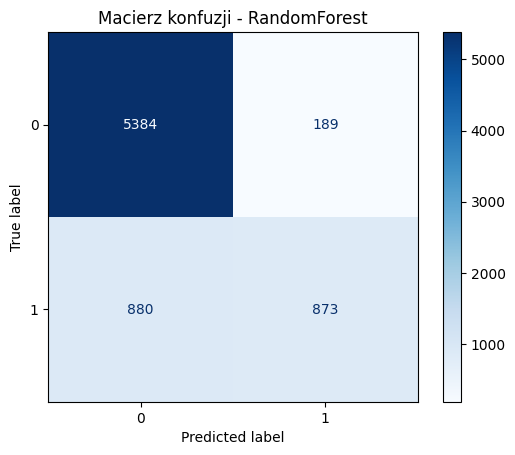

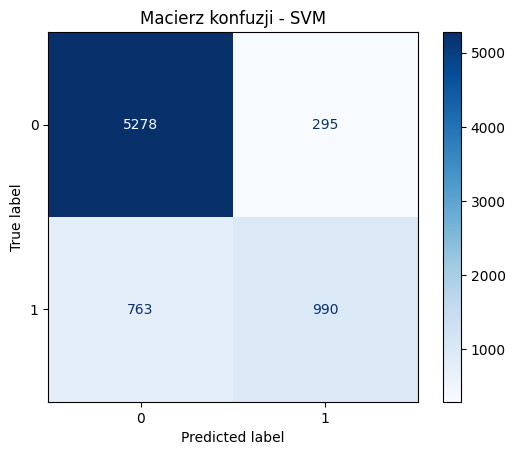

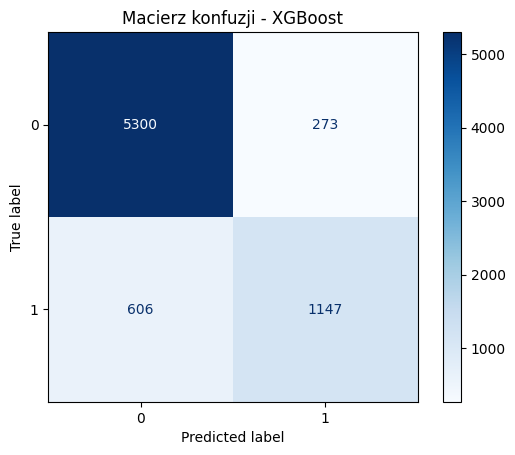

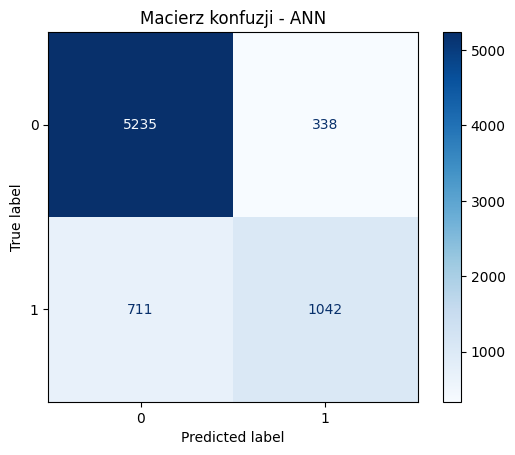

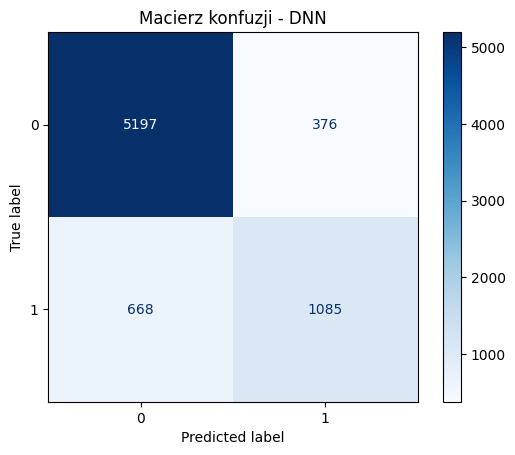

In [10]:
for name, cm in confusion_matrices.items():
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Macierz konfuzji - {name}")
    plt.show()

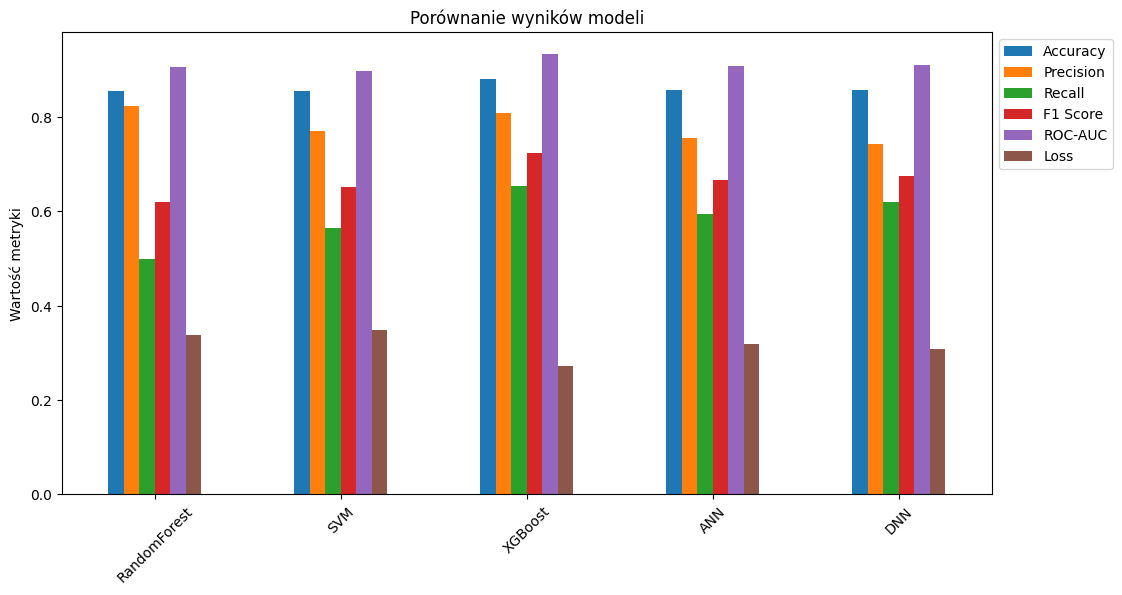

In [11]:
def plot_comparison_results():
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC", "Loss"]

    comparison_data = {}
    for metric in metrics:
        comparison_data[metric] = [results[model].get(metric, 0) for model in models]

    df_comparison = pd.DataFrame(comparison_data, index=models.keys())
    df_comparison.plot(kind='bar', figsize=(12, 6))
    plt.title("Porównanie wyników modeli")
    plt.ylabel("Wartość metryki")
    plt.xticks(rotation=45)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

plot_comparison_results()

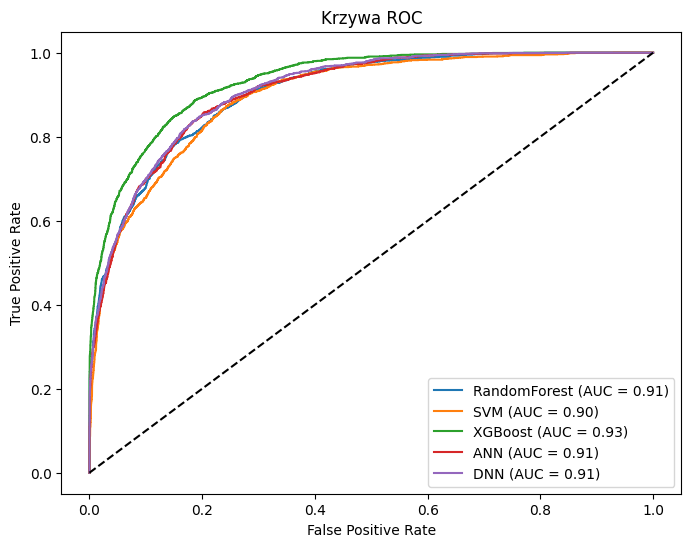

In [12]:
plt.figure(figsize=(8, 6))
for name, y_prob in y_prob_dict.items():
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_val, y_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend()
plt.show()

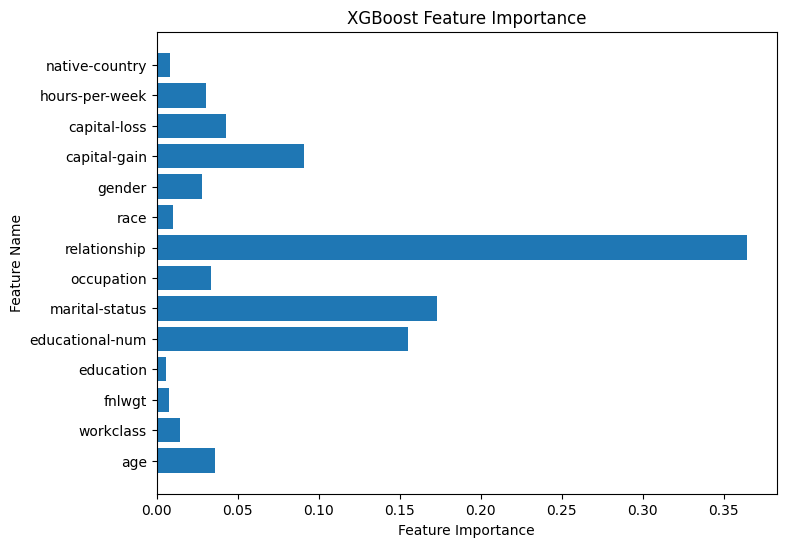

In [13]:
xgb_model = models["XGBoost"]

# xgb_model.fit(preprocessor.fit_transform(x_train), y_train)

plt.figure(figsize=(8, 6))
plt.barh(x_train.columns, xgb_model.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('XGBoost Feature Importance')
plt.show()

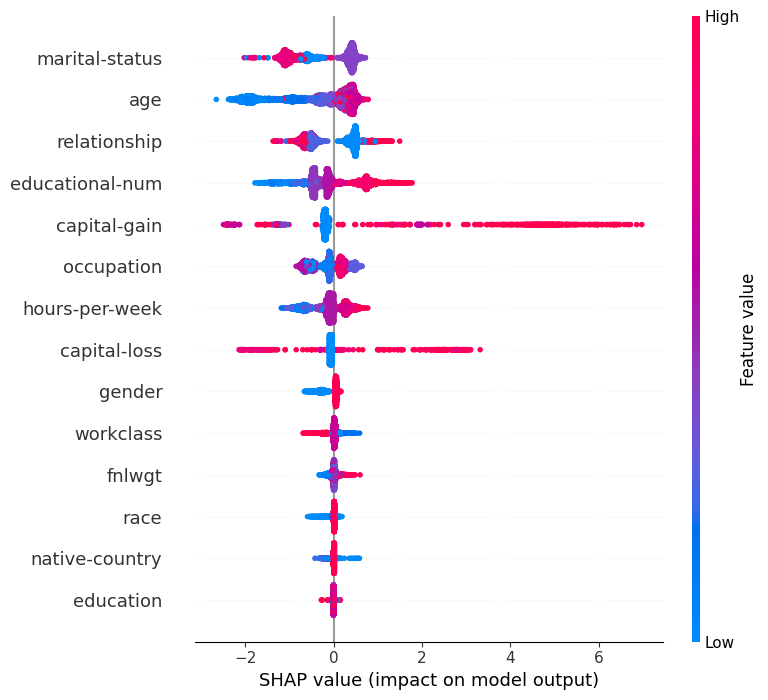

In [14]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(preprocessor.transform(x_val))
shap.summary_plot(shap_values, preprocessor.transform(x_val), feature_names=x_val.columns)

In [ ]:
# folder_path = "modele/"

# models = {}
# for model_name in ["RandomForest", "SVM", "XGBoost"]:
#     models[model_name] = joblib.load(folder_path + f"{model_name}.pkl")
#     print(f"Model {model_name} wczytany pomyślnie.")

# Optymalizacja klasycznych modeli
# RandomForest i XGBoost

Najpierw dokonujemy optymalizacji hiperparametrów dla klasycznych modeli (RandomForest i XGBoost), wykorzystując metodę RandomizedSearchCV. Celem jest znalezienie najlepszych wartości hiperparametrów dla każdego z modeli, co pozwala na poprawę ich wydajności. Przeszukujemy przestrzenie hiperparametrów zdefiniowane dla każdego modelu oraz ustalamy odpowiednie kryteria oceny na metrykach accuracy i f1, z priorytetem na f1 jako główne kryterium refitu.

Optymalizacja odbywa się na zbiorze treningowym, przy użyciu walidacji krzyżowej (5-krotna walidacja strat, StratifiedKFold), co zapewnia, że model będzie lepiej generalizował na niezbalansowanych danych, poprzez równomierne rozdzielenie klas w każdej z krotek walidacyjnych.

Ze względu na bardzo długi czas wykonywania kodu, dla modelu SVM przeprowadzimy osobną optymalizację na mniejszej przstrzeni parametrów do sprawdzenia.

In [73]:
# przestrzenie hiperparametrów do przeszukania
param_grids = {
    "RandomForest": {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [3, 5, 10],
        "model__min_samples_split": [2, 5, 10]
    },
    "XGBoost": {
        "model__n_estimators": [50, 100, 200],
        "model__max_depth": [3, 5, 10],
        "model__learning_rate": [0.01, 0.1, 0.3]
    }
}

best_models = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # kroswalidacja strat 5fold

for name, param_grid in param_grids.items():
    print(f"Optymalizacja hiperparametrów dla: {name}")

    model = models[name]
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=10,
        cv=cv,
        scoring=["accuracy", "f1"],
        refit="f1",
        n_jobs=-1,
        verbose=1
    )

    search.fit(x_train, y_train)

    best_models[name] = search.best_estimator_
    print(f"Najlepsze parametry dla {name}: {search.best_params_}")


Optymalizacja hiperparametrów dla: RandomForest
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Najlepsze parametry dla RandomForest: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__max_depth': 10}
Optymalizacja hiperparametrów dla: XGBoost
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Najlepsze parametry dla XGBoost: {'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.3}


Z wyników optymalizacji RandomizedSearchCV możemy zauważyć, że dla modelu RandomForest najlepsze parametry to 100 drzew, maksymalna głębokość 10 oraz minimum 5 próbek do podziału, co wskazuje na preferencję dla stosunkowo prostego modelu z umiarkowaną głębokością drzewa. Dla modelu XGBoost optymalnymi parametrami okazały się 200 drzew, maksymalna głębokość 5 oraz learning rate = 0.3, co wskazuje na stosunkowo szybkie uczenie się przy większej liczbie drzew.

Biorąc pod uwagę te wyniki, przeprowadzimy dokładniejszą optymalizację za pomocą GridSearchCV, w celu dokładniejszego przeszukania przestrzeni hiperparametrów dla najlepszych parametrów uzyskanych z RandomizedSearchCV.
Optymalizacja zostanie przeprowadzona na zawężonych zakresach hiperparametrów, co pozwoli na dokładniejsze dopasowanie modelu.

In [16]:
# refined parametry
refined_param_grids = {
    "RandomForest": {
        "model__n_estimators": [75, 100, 125, 150],
        "model__max_depth": [5, 10, 15, 20],
        "model__min_samples_split": [3, 4, 5, 6]
    },
    "XGBoost": {
        "model__n_estimators": [150, 180, 200, 250],
        "model__max_depth": [3, 4, 5, 6],
        "model__learning_rate": [0.1, 0.2, 0.3, 0.4],
        "model__gamma": [0, 0.1, 0.2],
        "model__reg_alpha": [0, 0.1, 0.2],
        "model__reg_lambda": [1, 1.5, 2]
    }
}

grid_search_models = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, param_grid in refined_param_grids.items():
    print(f"Dokładna optymalizacja hiperparametrów dla: {name}")

    model = models[name]
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring="f1_weighted",
        n_jobs=-1,
        verbose=1
    )

    search.fit(x_train, y_train)

    grid_search_models[name] = search.best_estimator_
    print(f"Najlepsze parametry dla {name} (Grid Search): {search.best_params_}\n")

Dokładna optymalizacja hiperparametrów dla: RandomForest
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Najlepsze parametry dla RandomForest (Grid Search): {'model__max_depth': 20, 'model__min_samples_split': 6, 'model__n_estimators': 100}

Dokładna optymalizacja hiperparametrów dla: XGBoost
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Najlepsze parametry dla XGBoost (Grid Search): {'model__gamma': 0.2, 'model__learning_rate': 0.2, 'model__max_depth': 4, 'model__n_estimators': 250, 'model__reg_alpha': 0.2, 'model__reg_lambda': 1.5}



Dla RandomForest najlepsze parametry to maksymalna głębokość 20, minimalna liczba próbek do podziału 6 oraz 100 drzew. Sugeruje to, że model osiąga lepsze wyniki przy głębszych drzewach, ale z umiarkowaną liczbą drzew, co zapobiega nadmiernemu dopasowaniu.

Dla XGBoost najlepsze parametry to: 250 drzew, maksymalna głębokość 4, learning rate = 0.2, gamma = 0.2 oraz regularyzacja alpha = 0.2 i lambda = 1.5. Wskazuje to na większą liczbę drzew oraz bardziej wyważoną regularyzację, co pozwala na lepszą generalizację modelu. Te wyniki mogą sugerować bardziej złożony model, który dobrze balansuje między dokładnością a generalizacją.

Dokładne porównanie wyników przed i po GridSearchCV:

In [18]:
# funkcja do oceny modelu i zapisania wyników
def evaluate_model(model, x_val, y_val, model_name, results):
    y_pred = model.predict(x_val)
    y_prob = None
    y_prob = model.predict_proba(x_val)[:, 1]  # dla binarnej klasyfikacji

    results[model_name] = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, average='weighted'),
        "Recall": recall_score(y_val, y_pred, average='weighted'),
        "F1 Score": f1_score(y_val, y_pred, average='weighted'),
        "ROC-AUC": roc_auc_score(y_val, y_prob) if y_prob is not None else None
    }

results_rf_xgb = {}

evaluate_model(best_models['RandomForest'], x_val, y_val, f"RandomForest (RandomizedSearchCV)", results_rf_xgb)
evaluate_model(grid_search_models['RandomForest'], x_val, y_val, f"RandomForest (GridSearchCV)", results_rf_xgb)
# DODAC XGBOOST???
evaluate_model(best_models['XGBoost'], x_val, y_val, f"XGBoost (RandomizedSearchCV)", results_rf_xgb)
evaluate_model(grid_search_models['XGBoost'], x_val, y_val, f"XGBoost (GridSearchCV)", results_rf_xgb)

results_rf_xgb_df = pd.DataFrame(results_rf_xgb).T
print("\nWyniki dla najlepszych modeli:")
print(results_rf_xgb_df)


Wyniki dla najlepszych modeli:
                                   Accuracy  Precision    Recall  F1 Score  \
RandomForest (RandomizedSearchCV)  0.864182   0.859752  0.864182  0.854762   
RandomForest (GridSearchCV)        0.870734   0.865793  0.870734  0.865273   
XGBoost (RandomizedSearchCV)       0.879607   0.875522  0.879607  0.875521   
XGBoost (GridSearchCV)             0.881108   0.877170  0.881108  0.877270   

                                    ROC-AUC  
RandomForest (RandomizedSearchCV)  0.919454  
RandomForest (GridSearchCV)        0.919287  
XGBoost (RandomizedSearchCV)       0.932000  
XGBoost (GridSearchCV)             0.932360  


Optymalizacja hiperparametrów przyniosła zauważalną poprawę wyników. GridSearchCV pozwolił na uzyskanie lepszych wyników niż RandomizedSearchCV w obu modelach, co pokazuje, że dokładniejsze przeszukiwanie przestrzeni hiperparametrów było korzystne.

RandomForest po GridSearchCV osiągnął wyższą dokładność i lepszą precyzję, co wskazuje na lepszą zdolność do prawidłowego klasyfikowania przypadków pozytywnych.
Dokładne dostrajanie hiperparametrów pozwoliło uzyskać stabilniejsze i bardziej efektywne modele, szczególnie w przypadku XGBoost.

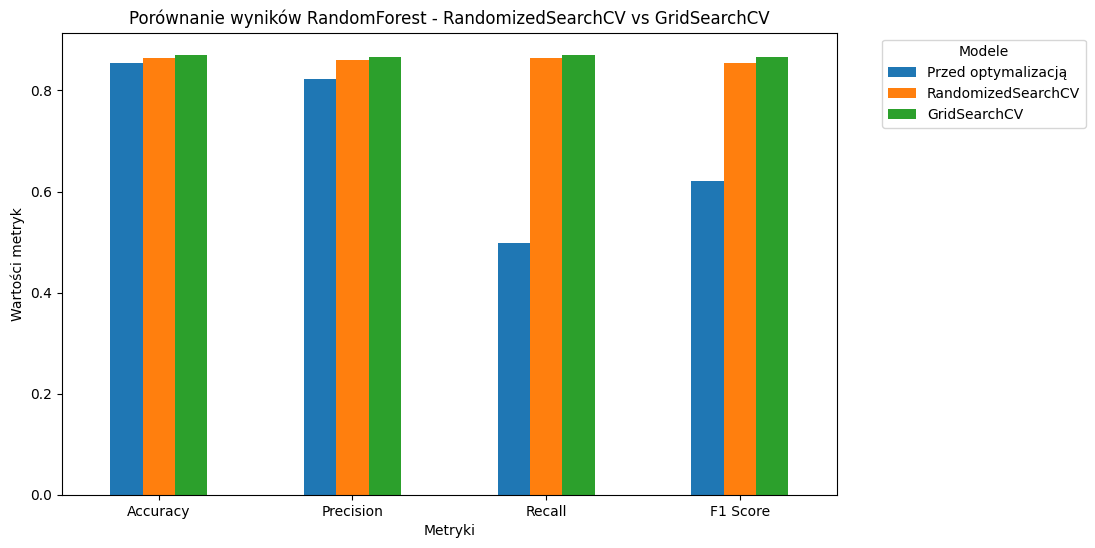

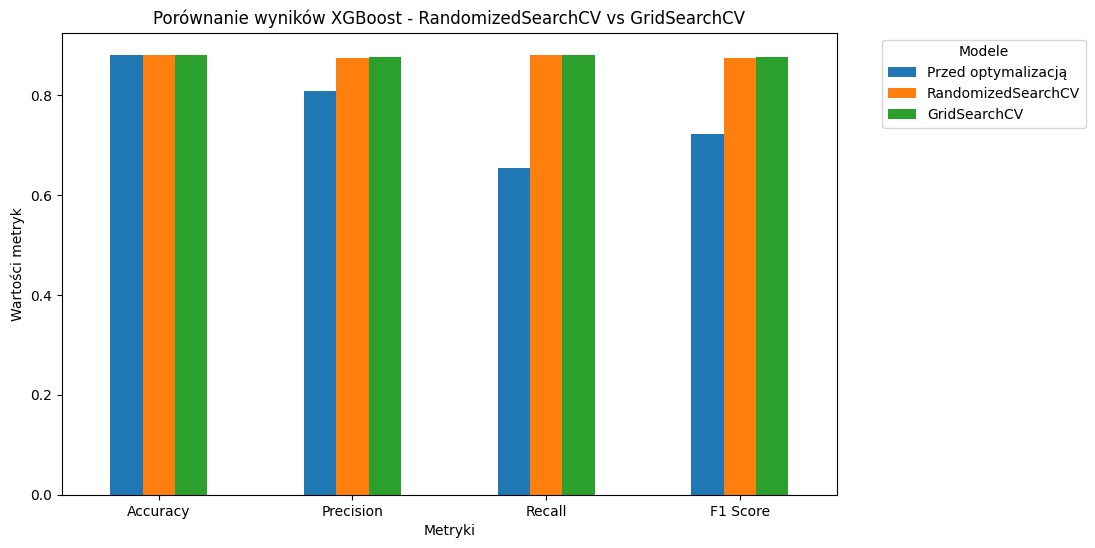

In [19]:
# porównanie wyników po RandomizedSearchCV i GridSearchCV
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# wyniki dla RandomForest do wykresu
results_comparison_rf = {
    "Przed optymalizacją": [results["RandomForest"][metric] for metric in metrics],
    "RandomizedSearchCV": results_rf_xgb_df.loc["RandomForest (RandomizedSearchCV)", metrics].values,
    "GridSearchCV": results_rf_xgb_df.loc["RandomForest (GridSearchCV)", metrics].values
}

# wyniki dla RandomForest do wykresu
results_comparison_xgb = {
    "Przed optymalizacją": [results["XGBoost"][metric] for metric in metrics],
    "RandomizedSearchCV": results_rf_xgb_df.loc["XGBoost (RandomizedSearchCV)", metrics].values,
    "GridSearchCV": results_rf_xgb_df.loc["XGBoost (GridSearchCV)", metrics].values
}

# dataframe do wykresu
comparison_rf_df = pd.DataFrame(results_comparison_rf, index=metrics)
comparison_xgb_df = pd.DataFrame(results_comparison_xgb, index=metrics)

comparison_rf_df.plot(kind='bar', figsize=(10, 6))
plt.title('Porównanie wyników RandomForest - RandomizedSearchCV vs GridSearchCV')
plt.ylabel('Wartości metryk')
plt.xlabel('Metryki')
plt.xticks(rotation=0)
plt.legend(title='Modele', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

comparison_xgb_df.plot(kind='bar', figsize=(10, 6))
plt.title('Porównanie wyników XGBoost - RandomizedSearchCV vs GridSearchCV')
plt.ylabel('Wartości metryk')
plt.xlabel('Metryki')
plt.xticks(rotation=0)
plt.legend(title='Modele', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Optymalizacja SVM
Optymalizację hiperparametrów dla modelu SVM także przeprowadzimy przy użyciu GridSearchCV. Przeszukamy przestrzeń hiperparametrów dla dwóch parametrów: C (wartości: 0.1, 1, 10) oraz kernel (rbf i linear). Wykorzystamy walidację krzyżową 3-krotną dla szybszej oceny modelu.

In [17]:
svm_grid = {
    "model__C": [0.1, 1, 10],
    "model__kernel": ["rbf", "linear"]
}

svm_model = models["SVM"]
svm_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", svm_model)])

svm_search = GridSearchCV(
    svm_pipeline,
    param_grid=svm_grid,
    cv=3,  # szybsza kroswalidacja
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

svm_search.fit(x_train, y_train)
best_models["SVM"] = svm_search.best_estimator_
print(f"Najlepsze parametry dla SVM: {svm_search.best_params_}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Najlepsze parametry dla SVM: {'model__C': 1, 'model__kernel': 'rbf'}


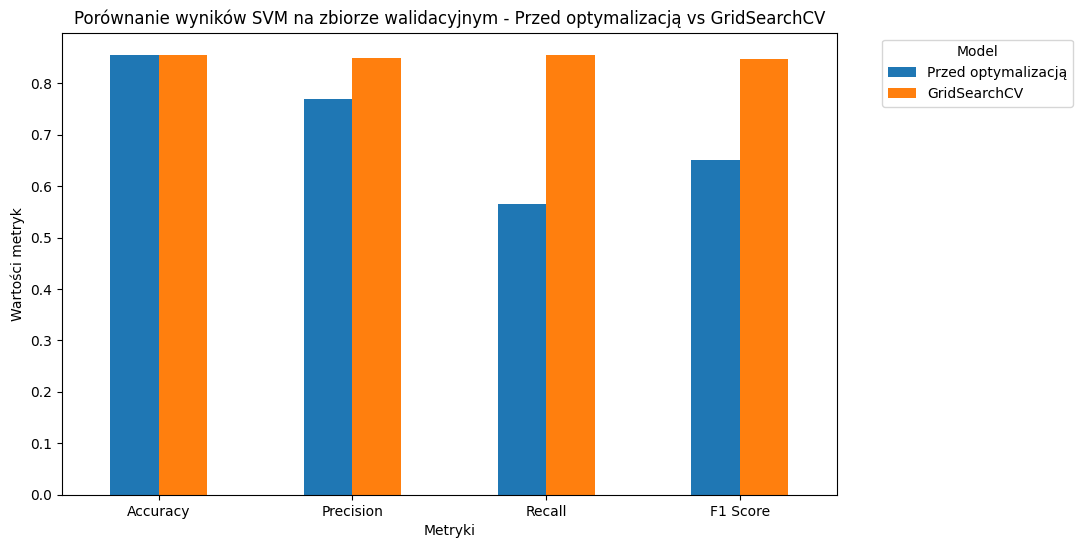

In [20]:
y_val_pred_svm = best_models["SVM"].predict(x_val)

svm_optimized_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred_svm),
    "Precision": precision_score(y_val, y_val_pred_svm, average="weighted"),
    "Recall": recall_score(y_val, y_val_pred_svm, average="weighted"),
    "F1 Score": f1_score(y_val, y_val_pred_svm, average="weighted")
}


metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

results_comparison_svm = {
    "Przed optymalizacją": [results["SVM"][metric] for metric in metrics],
    "GridSearchCV": [svm_optimized_metrics[metric] for metric in metrics]
}

comparison_svm_df = pd.DataFrame(results_comparison_svm, index=metrics)

comparison_svm_df.plot(kind='bar', figsize=(10, 6))
plt.title('Porównanie wyników SVM na zbiorze walidacyjnym - Przed optymalizacją vs GridSearchCV')
plt.ylabel('Wartości metryk')
plt.xlabel('Metryki')
plt.xticks(rotation=0)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Mimo że GridSearchCV wskazał te same parametry (C=1, kernel=rbf), które były użyte wcześniej, wyniki po optymalizacji są wyraźnie lepsze. Różnice wynikają najprawdopodobniej z zastosowania pełnego pipeline’u z preprocessingiem oraz kroswalidacji w GridSearchCV, co zapewniło lepsze przygotowanie danych i bardziej stabilne dopasowanie modelu. Dzięki temu poprawiły się metryki, zwłaszcza Recall i F1 Score.

# Zapisujemy najlepsze modele
Wybór najlepszej wersji modelu opieramy na F1 Score, ponieważ jest to metryka, która uwzględnia zarówno precyzję, jak i recall, co jest szczególnie istotne w przypadku niezbalansowanego zbioru danych. Wybór na podstawie F1 Score zapewnia, że model dobrze identyfikuje zarówno pozytywne, jak i negatywne przypadki.

In [21]:
# zaktualizowanie best_models na podstawie wyników GridSearch, jeśli wyniki są lepsze
# porównujemy wyniki po RandomizedSearchCV i GridSearchCV
if results_rf_xgb_df.loc["RandomForest (GridSearchCV)", "F1 Score"] > results_rf_xgb_df.loc["RandomForest (RandomizedSearchCV)", "F1 Score"]:
    best_models['RandomForest'] = grid_search_models['RandomForest']
    print("\nAktualizacja: RandomForest GridSearchCV")
else:
    print("\nAktualizacja: RandomForest RandomizedSearchCV")

if results_rf_xgb_df.loc["XGBoost (GridSearchCV)", "F1 Score"] > results_rf_xgb_df.loc["XGBoost (RandomizedSearchCV)", "F1 Score"]:
    best_models['XGBoost'] = grid_search_models['XGBoost']
    print("\nAktualizacja: XGBoost GridSearchCV")
else:
    print("\nAktualizacja: XGBoost RandomizedSearchCV")



Aktualizacja: RandomForest GridSearchCV

Aktualizacja: XGBoost GridSearchCV


In [22]:
# folder_path = "modele/"

# for name in ["RandomForest", "SVM", "XGBoost"]:
#   joblib.dump(best_models[name], folder_path + f"best_{name}.pkl")

# Optymalizacja ANN
W celu optymalizacji sieci neuronowej testowane będą różne architektury i hiperparametry, aby znaleźć najlepszy zestaw ustawień. Sprawdzane będą: liczba warstw (2–3), liczba neuronów w każdej warstwie (64–384), funkcje aktywacji (relu, selu, tanh, elu) oraz współczynnik dropout (0.1–0.3). Dodatkowo, zastosowano regularyzację L2, normalizację batchową oraz różne optymalizatory z dynamicznie dobieranym learning rate. W celu poprawy stabilności gradientów wykorzystano mechanizm clipnorm, a metryki dla każdego modelu są zapisywane w trakcie trenowania, co umożliwia ich późniejsze porównanie.

In [31]:
# funkcja budująca model ann
def build_ann(hp):
    model = Sequential()

    # testowanie liczby warstw (2-3 warstwy)
    num_layers = hp.Int("num_layers", 2, 3)

    # generowanie parametrów dla każdej warstwy
    for i in range(num_layers):
        units = hp.Int(f"units{i+1}", min_value=64, max_value=384, step=64)
        activation = hp.Choice(f"activation{i+1}", values=["relu", "selu", "tanh", "elu"])
        dropout_rate = hp.Float(f"dropout{i+1}", min_value=0.1, max_value=0.3, step=0.05)

        model.add(Dense(units, kernel_regularizer=regularizers.l2(0.001)))  # l2 regularization
        model.add(BatchNormalization())
        model.add(Activation(activation))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="sigmoid"))

    # testowanie optymalizatorów
    optimizer = hp.Choice("optimizer", values=["adam", "sgd", "rmsprop", "nadam"])
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=5e-3, sampling="log")

    if optimizer == "adam":
        chosen_optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)  # stabilizacja gradientów
    elif optimizer == "sgd":
        chosen_optimizer = SGD(learning_rate=learning_rate, clipnorm=1.0)
    elif optimizer == "rmsprop":
        chosen_optimizer = RMSprop(learning_rate=learning_rate, clipnorm=1.0)
    else:
        chosen_optimizer = Nadam(learning_rate=learning_rate, clipnorm=1.0)

    model.compile(
        optimizer=chosen_optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


# metryki wszystkich modeli
ann_metrics = []

# callback do zapisywania metryk dla każdego modelu
class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        train_accuracy = logs.get('accuracy')
        val_loss = logs.get('val_loss')
        val_accuracy = logs.get('val_accuracy')
        ann_metrics.append({
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        })


Tym razem zamiast losowego przeszukiwania hiperparametrów sprawdzamy metodę optymalizacji bayesowskiej, która dynamicznie dostosowuje kolejne próby na podstawie wcześniejszych wyników. Dzięki temu możemy efektywniej eksplorować przestrzeń hiperparametrów, unikając zbędnych testów i szybciej znajdując lepsze konfiguracje.

In [33]:
# losowość dla powtarzalnych wyników
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# tuner bayesian pptimization
tuner_ann = kt.BayesianOptimization(
    build_ann,
    objective="val_loss",  # loss żeby kontrolować overfitting
    max_trials=15,
    executions_per_trial=1,
    num_initial_points=7,  # więcej losowych próbek na początku = większa eksploracja
    directory="tuning_results",
    project_name="ann_bayesian_optimization",
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=0.0001,  # mniejsze zmiany do zatrzymania
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "ann/ANN_opt_1.keras",
    save_best_only=True,
    monitor="val_loss",  # najlepszy model na podstawie straty
    mode="min",
    verbose=0
)

# przygotowanie danych
x_train_processed = preprocessor.fit_transform(x_train)
x_val_processed = preprocessor.transform(x_val)

# optymalizacja
tuner_ann.search(
    x_train_processed,
    y_train,
    epochs=25,
    validation_data=(x_val_processed, y_val),
    verbose=1,
    callbacks=[early_stopping, checkpoint, MetricsCallback()]
)

# najlepsze wyniki
best_ann_hyperparameters = tuner_ann.get_best_hyperparameters(num_trials=1)[0]
print("Najlepsze hiperparametry ANN:", best_ann_hyperparameters.values)

best_ann_1 = build_ann(best_ann_hyperparameters)

# ponowne trenowanie modelu z najlepszymi hiperparametrami
best_ann_1.fit(
    x_train_processed,
    y_train,
    epochs=25,
    validation_data=(x_val_processed, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

best_ann_1.load_weights("ann/ANN_opt_1.keras")


Trial 15 Complete [00h 02m 54s]
val_loss: 0.32430803775787354

Best val_loss So Far: 0.32430803775787354
Total elapsed time: 00h 49m 57s
Najlepsze hiperparametry ANN: {'num_layers': 2, 'units1': 64, 'activation1': 'relu', 'dropout1': 0.2, 'units2': 64, 'activation2': 'tanh', 'dropout2': 0.15000000000000002, 'optimizer': 'nadam', 'learning_rate': 0.0002484022817018141, 'units3': 256, 'activation3': 'tanh', 'dropout3': 0.1}
Epoch 1/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7043 - loss: 0.6454 - val_accuracy: 0.8417 - val_loss: 0.4262
Epoch 2/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8175 - loss: 0.4624 - val_accuracy: 0.8462 - val_loss: 0.3990
Epoch 3/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8203 - loss: 0.4378 - val_accuracy: 0.8490 - val_loss: 0.3849
Epoch 4/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8296 - loss: 0.4177 - val_accuracy: 0.8522 - val_loss: 0.3758
Epoch 5/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step

Po optymalizacji ANN uzyskano lepszą architekturę sieci, składającą się z 3 warstw ukrytych, zróżnicowanymi aktywacjami i dropoutem, zoptymalizowanym learning_rate oraz użyciem optymalizatora nadam. Choć końcowa wartość val_loss (0.3243) jest minimalnie większa od wcześniejszej (0.3188), sama struktura modelu jest bardziej rozbudowana i dopasowana do danych.
W porównaniu do poprzedniego, prostszego modelu (2 warstwy + sigmoid), nowy model powinien lepiej generalizować, szczególnie przy bardziej złożonych danych.

In [35]:
# # zapis do pliku
# with open("ann/best_ann_hyperparameters.pkl", "wb") as f:
#     pickle.dump(best_ann_hyperparameters, f)

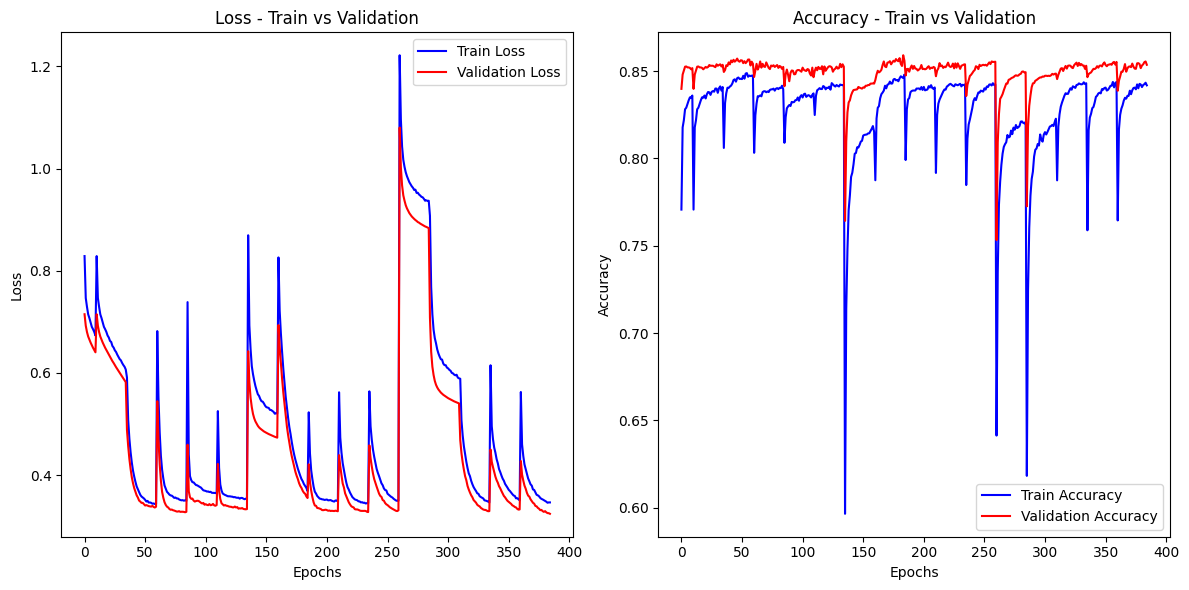

In [34]:
# WSZYSTKIE WYNIKI

# pobieranie wszystkich metryk z callbacka
train_losses = [metrics['train_loss'] for metrics in ann_metrics]
train_accuracies = [metrics['train_accuracy'] for metrics in ann_metrics]
val_losses = [metrics['val_loss'] for metrics in ann_metrics]
val_accuracies = [metrics['val_accuracy'] for metrics in ann_metrics]

plt.figure(figsize=(12, 6))

# wykres dla train loss i val loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Loss - Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# wykres dla train acc i val acc
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Accuracy - Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Wykresy pokazują, że po optymalizacji model ANN osiągnął bardzo dobrą stabilność — zarówno strata, jak i dokładność dla zbioru treningowego i walidacyjnego są zbliżone, bez oznak przeuczenia.

Sprawdzimy czy kontynuowanie uczenia najlepszego modelu poprawi jego wyniki na danych walidacyjnych. Po wybraniu najlepszych hiperparametrów i zastosowaniu dynamicznego schematu nauki, model może dalej optymalizować swoje wagi i dostosować się do wzorców w danych. Aby uniknąć przeuczenia modelu zastosujemy zatrzymanie treningu, gdy model przestaje się poprawiać oraz redukcje tempa uczenia się, gdy model utknie w miejscach z małą poprawą. Następnie zachowamy najlepszy model, który osiągnie najlepsze wyniki walidacyjne.

In [ ]:
# # odczyt z pliku
# with open("ann/best_ann_hyperparameters.pkl", "rb") as f:
#     best_ann_hyperparameters = pickle.load(f)

In [36]:
# najlepsz3 hiperparametry z poprzedniego tuningu
best_hp = best_ann_hyperparameters

# model na bazie najlepszych hiperparametrów
def fine_tune_ann():
    model = Sequential()

    for i in range(best_hp.get("num_layers")):
        units = best_hp.get(f"units{i+1}")
        activation = best_hp.get(f"activation{i+1}")
        dropout_rate = max(0.05, best_hp.get(f"dropout{i+1}") - 0.05)

        model.add(Dense(units, kernel_regularizer=regularizers.l2(0.0007)))  # lekko zmniejszone L2
        model.add(BatchNormalization())
        model.add(Activation(activation))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="sigmoid"))

    # harmonogram uczenia się (learning rate decay)
    initial_lr = best_hp.get("learning_rate")
    lr_schedule = ExponentialDecay(initial_lr, decay_steps=1000, decay_rate=0.96, staircase=True)

    # użycie najlepszego optymalizatora
    optimizer_choice = best_hp.get("optimizer")
    if optimizer_choice == "adam":
        optimizer = Adam(learning_rate=lr_schedule, clipnorm=1.0)
    elif optimizer_choice == "sgd":
        optimizer = SGD(learning_rate=lr_schedule, momentum=0.9, clipnorm=1.0)
    elif optimizer_choice == "rmsprop":
        optimizer = RMSprop(learning_rate=lr_schedule, clipnorm=1.0)
    else:
        optimizer = Nadam(learning_rate=lr_schedule, clipnorm=1.0)

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

fine_tuned_ann = fine_tune_ann()

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=0.0001,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "ann/ANN_opt_2.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

# przygotowanie danych
x_train_processed = preprocessor.fit_transform(x_train)
x_val_processed = preprocessor.transform(x_val)

history = fine_tuned_ann.fit(
    x_train_processed,
    y_train,
    epochs=50,
    validation_data=(x_val_processed, y_val),
    batch_size=64,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


fine_tuned_ann.load_weights("ann/ANN_opt_2.keras")

# najlepsze wyniki walidacyjne
best_val_acc = max(history.history["val_accuracy"])
best_val_loss = min(history.history["val_loss"])

print(f"Best validation accuracy: {best_val_acc:.5f}")
print(f"Best validation loss: {best_val_loss:.5f}")

Epoch 1/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6979 - loss: 0.6351 - val_accuracy: 0.8331 - val_loss: 0.4315
Epoch 2/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8086 - loss: 0.4663 - val_accuracy: 0.8380 - val_loss: 0.4044
Epoch 3/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8195 - loss: 0.4337 - val_accuracy: 0.8429 - val_loss: 0.3876
Epoch 4/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8255 - loss: 0.4147 - val_accuracy: 0.8475 - val_loss: 0.3769
Epoch 5/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8261 - loss: 0.4070 - val_accuracy: 0.8481 - val_loss: 0.3714
Epoch 6/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8327 - loss: 0.3961 - val_accuracy: 0.8494 - val_loss: 0.3657
Epoch 7/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8369 - loss: 0.3928 - val_accuracy: 0.8496 - val_loss: 0.3628
Epoch 8/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8364 - loss: 0.3860 - val_accuracy: 0.

Ostatecznie dla modelu ANN udało nam się osiągnąć minimalnie lepsze wyniki. W celu dokładniejszego porównania zwizualizujemy wyniki modeli na wykresach.

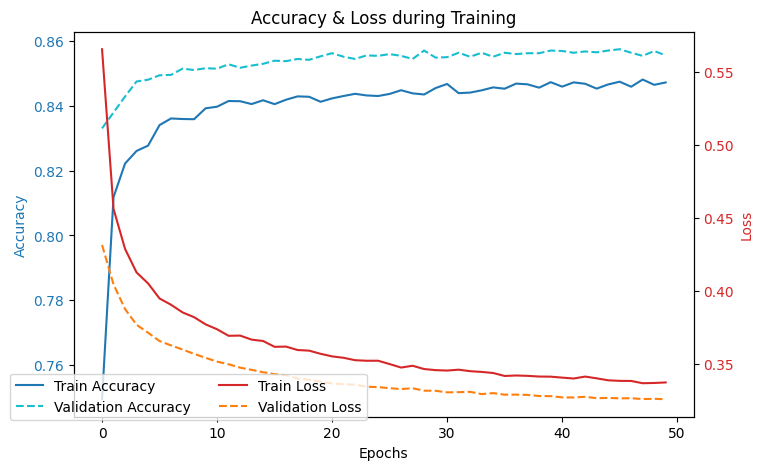

In [37]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# acc
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(history.history['accuracy'], label='Train Accuracy', color='tab:blue', linestyle='solid')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='tab:cyan', linestyle='dashed')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(history.history['loss'], label='Train Loss', color='tab:red', linestyle='solid')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='tab:orange', linestyle='dashed')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.legend(loc='right', bbox_to_anchor=(0.5, 0.15), ncol=2)

plt.title('Accuracy & Loss during Training')
plt.show()

Wyniki przedstawione na wykresie pokazują, że proces dalszej optymalizacji modelu ANN przebiegł bardzo dobrze. Krzywe dokładności dla zbioru treningowego i walidacyjnego są stabilne i zbliżone, co sugeruje brak przeuczenia. Jednocześnie oba wykresy strat systematycznie maleją, a walidacyjna strata utrzymuje się na niskim poziomie przez cały czas treningu. Oznacza to, że model skutecznie uczy się reprezentować dane bez utraty ogólności i dobrze generalizuje na danych walidacyjnych.

Ostateczną optymalizację najlepszego modelu ANN przeprowadzimy na pełnym zbiorze treningowym. Model ponownie wykorzystuje wcześniej wybrane hiperparametry, a dodatkowo zastosujemy lekką regularyzację L2, dynamiczne zmniejszanie learning rate oraz śledzenie jego zmian. Dane zostały przygotowane przy użyciu pełnego przetwarzania, a model trenowany z walidacją wewnętrzną i zapisem najlepszych wag. Pozwoli to w pełni wykorzystać dostępne dane i uzyskać model gotowy do finalnej oceny.

In [40]:
# śledzenie zmian learning rate
class LrTracker(Callback):
    def __init__(self):
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        self.lrs.append(tf.keras.backend.get_value(lr))

# pełny zbior treningowt
x_train_val_df = pd.concat([x_train, x_val], axis=0)
y_train_val_array = np.concatenate([y_train, y_val])

x_full = preprocessor.fit_transform(x_train_val_df)
y_full = y_train_val_array


def final_ann_model():
    model = Sequential()

    for i in range(best_hp.get("num_layers")):
        units = best_hp.get(f"units{i+1}")
        activation = best_hp.get(f"activation{i+1}")
        dropout_rate = max(0, best_hp.get(f"dropout{i+1}") - 0.05)

        model.add(Dense(units, kernel_regularizer=regularizers.l2(0.0005)))
        model.add(BatchNormalization())
        model.add(Activation(activation))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="sigmoid"))

    initial_lr = best_hp.get("learning_rate")
    lr_schedule = ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )

    optimizer_choice = best_hp.get("optimizer")
    if optimizer_choice == "adam":
        optimizer = Adam(learning_rate=lr_schedule, clipnorm=1.0)
    elif optimizer_choice == "sgd":
        optimizer = SGD(learning_rate=lr_schedule, momentum=0.9, clipnorm=1.0)
    elif optimizer_choice == "rmsprop":
        optimizer = RMSprop(learning_rate=lr_schedule, clipnorm=1.0)
    else:
        optimizer = Nadam(learning_rate=lr_schedule, clipnorm=1.0)

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model


final_ann = final_ann_model()

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("ann/ANN_final.keras", save_best_only=True, monitor="val_accuracy", mode="max")
lr_tracker = LrTracker()

final_history = final_ann.fit(
    x_full,
    y_full,
    epochs=50,
    batch_size=64,
    validation_split=0.1,  # walidacja z 10% danych treningowych
    callbacks=[early_stopping, checkpoint, lr_tracker],
    verbose=1
)

final_ann.load_weights("ann/ANN_final.keras")

best_val_acc = max(final_history.history["val_accuracy"])
best_val_loss = min(final_history.history["val_loss"])

print(f"Best validation accuracy: {best_val_acc:.5f}")
print(f"Best validation loss: {best_val_loss:.5f}")

Epoch 1/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6860 - loss: 0.6232 - val_accuracy: 0.8408 - val_loss: 0.4065
Epoch 2/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8178 - loss: 0.4371 - val_accuracy: 0.8485 - val_loss: 0.3704
Epoch 3/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8273 - loss: 0.4080 - val_accuracy: 0.8483 - val_loss: 0.3610
Epoch 4/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8346 - loss: 0.3947 - val_accuracy: 0.8492 - val_loss: 0.3554
Epoch 5/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8321 - loss: 0.3859 - val_accuracy: 0.8519 - val_loss: 0.3511
Epoch 6/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8370 - loss: 0.3815 - val_accuracy: 0.8516 - val_loss: 0.3480
Epoch 7/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8375 - loss: 0.3757 - val_accuracy: 0.8507 - val_loss: 0.3463
Epoch 8/50
584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8390 - loss: 0.3743 - val_accuracy: 0.

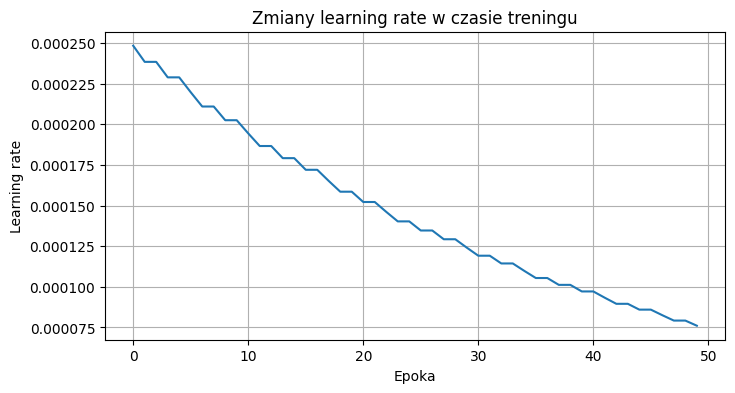

In [41]:
plt.figure(figsize=(8, 4))
plt.plot(lr_tracker.lrs)
plt.title("Zmiany learning rate w czasie treningu")
plt.xlabel("Epoka")
plt.ylabel("Learning rate")
plt.grid(True)
plt.show()

Wykres przedstawia systematyczne zmniejszanie się learning rate podczas treningu modelu, zgodnie z zastosowanym harmonogramem ExponentialDecay. Początkowa wartość stopniowo maleje, co pozwala modelowi najpierw szybko się uczyć, a następnie delikatnie dopracowywać wagę bez gwałtownych zmian.

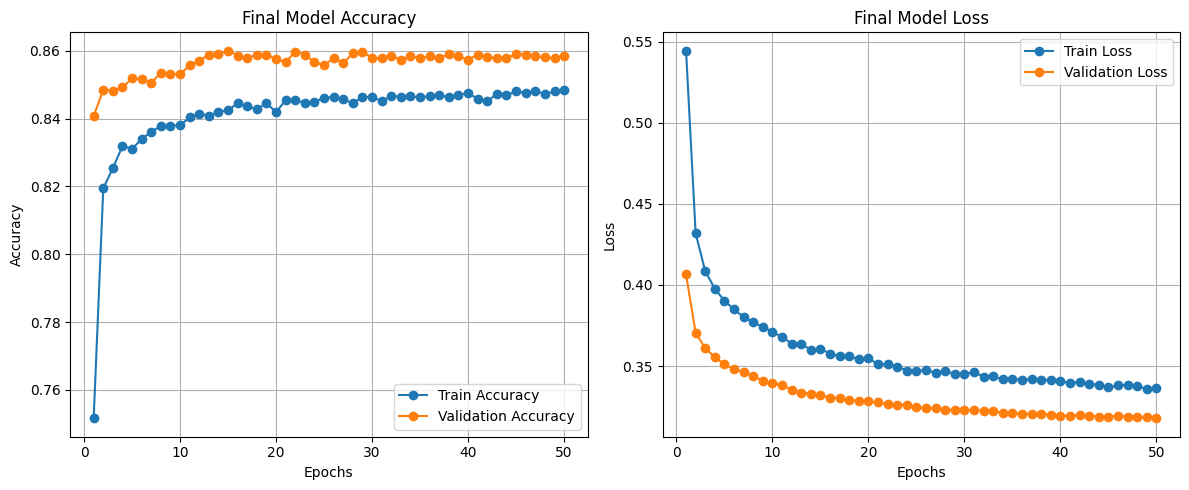

In [42]:
acc = final_history.history["accuracy"]
val_acc = final_history.history["val_accuracy"]
loss = final_history.history["loss"]
val_loss = final_history.history["val_loss"]

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Accuracy", marker='o')
plt.plot(epochs_range, val_acc, label="Validation Accuracy", marker='o')
plt.title("Final Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss", marker='o')
plt.plot(epochs_range, val_loss, label="Validation Loss", marker='o')
plt.title("Final Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Wykresy pokazują bardzo dobre wyniki końcowego modelu ANN. Dokładność walidacyjna utrzymuje się na wysokim i stabilnym poziomie, przewyższając dokładność treningową, co może świadczyć o skutecznej regularyzacji i dobrej generalizacji. Jednocześnie loss systematycznie maleje dla obu zbiorów, bez oznak przeuczenia.

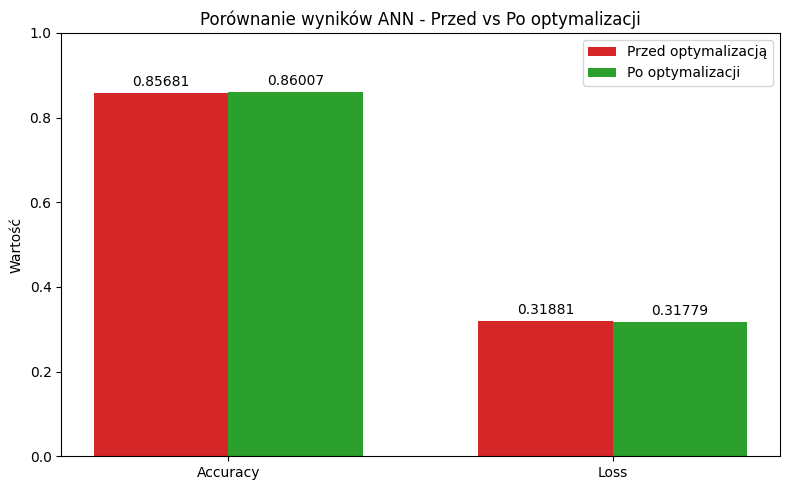

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# wyniki przed optymalizacją
ann_pre_acc = results["ANN"]["Accuracy"]
ann_pre_loss = results["ANN"]["Loss"]

# wyniki po optymalizacji
ann_post_acc = max(final_history.history["val_accuracy"])
ann_post_loss = min(final_history.history["val_loss"])

labels = ["Accuracy", "Loss"]
before = [ann_pre_acc, ann_pre_loss]
after = [ann_post_acc, ann_post_loss]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, before, width, label='Przed optymalizacją', color="#d62728")
bars2 = ax.bar(x + width/2, after, width, label='Po optymalizacji', color="#2ca02c")

ax.set_ylabel('Wartość')
ax.set_title('Porównanie wyników ANN - Przed vs Po optymalizacji')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.bar_label(bars1, fmt="%.5f", padding=3)
ax.bar_label(bars2, fmt="%.5f", padding=3)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

Jak widać, udało nam się uzyskać minimalnie lepsze wyniki. Mimo iż na pierwszy rzut oka ostatecznie nie udało się znacząco poprawić wyników dla tego modelu, zapiszemy uzyskany model jako wynik optymalizacji, w celu porównania końcowych wyników modeli i wszystkich ich metryk przed i po próbie optymalizacji.

In [47]:
# final_ann.save("modele/best_ANN.keras")

# Optymalizacja DNN
W celu optymalizacji modelu DNN wykorzystamy funkcję budującą model DNN z możliwością strojenia hiperparametrów takich jak liczba neuronów, funkcje aktywacji, dropout czy wybór optymalizatora. Model może opcjonalnie zawierać trzecią warstwę ukrytą. Wykorzystamy harmonogram zmniejszania learning rate oraz regularizację L2, co wspomaga stabilność uczenia oraz zastosujemy analogiczny callback jak w ANN do zapisywania metryk po każdej epoce, co umożliwia dokładną analizę wyników dla różnych konfiguracji.

In [8]:
# funkcja budująca model dnn
def build_dnn(hp):
    model = Sequential()

    # pierwsza warstwa
    units1 = hp.Int("units1", min_value=64, max_value=256, step=64)
    activation1 = hp.Choice("activation1", values=["relu", "selu", "tanh", "elu"])
    dropout1 = hp.Float("dropout1", min_value=0.1, max_value=0.3, step=0.05)

    model.add(Dense(units1, kernel_regularizer=regularizers.l2(0.0005), input_shape=(x_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Activation(activation1))
    model.add(Dropout(dropout1))

    # druga warstwa
    units2 = hp.Int("units2", min_value=32, max_value=128, step=32)
    activation2 = hp.Choice("activation2", values=["relu", "selu", "tanh", "elu"])
    dropout2 = hp.Float("dropout2", min_value=0.1, max_value=0.3, step=0.05)

    model.add(Dense(units2, kernel_regularizer=regularizers.l2(0.0005)))
    model.add(BatchNormalization())
    model.add(Activation(activation2))
    model.add(Dropout(dropout2))

    # trzecia warstwa opcjonalna
    if hp.Boolean("use_third_layer"):
        units3 = hp.Int("units3", min_value=16, max_value=64, step=16)
        activation3 = hp.Choice("activation3", values=["relu", "selu", "tanh", "elu"])
        dropout3 = hp.Float("dropout3", min_value=0.1, max_value=0.3, step=0.05)

        model.add(Dense(units3, kernel_regularizer=regularizers.l2(0.0005)))
        model.add(BatchNormalization())
        model.add(Activation(activation3))
        model.add(Dropout(dropout3))

    # warstwa wyjściowa
    model.add(Dense(1, activation="sigmoid"))

    # optymalizator
    optimizer_choice = hp.Choice("optimizer", values=["adam", "sgd", "rmsprop", "nadam"])
    # learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=5e-3, sampling="log")
    initial_lr = hp.Float("learning_rate", min_value=5e-4, max_value=2e-3, sampling="log")
    lr_schedule = ExponentialDecay(initial_lr, decay_steps=1000, decay_rate=0.96, staircase=True)

    if optimizer_choice == "adam":
        optimizer = Adam(learning_rate=lr_schedule, clipnorm=1.0)
    elif optimizer_choice == "sgd":
        optimizer = SGD(learning_rate=lr_schedule, clipnorm=1.0, momentum=0.9)
    elif optimizer_choice == "rmsprop":
        optimizer = RMSprop(learning_rate=lr_schedule, clipnorm=1.0)
    else:
        optimizer = Nadam(learning_rate=lr_schedule, clipnorm=1.0)

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model


# metryki wszystkich modeli
dnn_metrics = []

# callback do zapisywania metryk dla każdego modelu
class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        train_accuracy = logs.get('accuracy')
        val_loss = logs.get('val_loss')
        val_accuracy = logs.get('val_accuracy')
        dnn_metrics.append({
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        })

We wstępnej optymalizacji modelu wykorzystamy tuner Hyperband do przeszukania przestrzeni hiperparametrów w oparciu o wartość funkcji straty walidacyjnej. Proces uwzględnia early stopping, dynamiczne zmniejszanie learning rate oraz zapis najlepszych wag.

In [9]:
# losowość dla powtarzalnych wyników
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


# tuner hyperband
tuner_dnn = kt.Hyperband(
    build_dnn,
    objective="val_loss",
    max_epochs=40,
    factor=5,
    hyperband_iterations=1,
    directory="tuning_results",
    project_name="dnn_hyperband_optimization",
    overwrite=True,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=4,
    min_lr=1e-5,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "dnn/DNN_opt_1.keras",
    monitor="val_loss",  # zmienione z val_accuracy
    save_best_only=True,
    mode="min",
    verbose=1
)

# przetwarzanie danych
x_train_processed = preprocessor.fit_transform(x_train)
x_val_processed = preprocessor.transform(x_val)

# optymalizacja
tuner_dnn.search(
    x_train_processed,
    y_train,
    epochs=40,
    validation_data=(x_val_processed, y_val),
    batch_size=128,
    verbose=1,
    callbacks=[early_stopping, reduce_lr, MetricsCallback()]
)

best_dnn_hyperparameters = tuner_dnn.get_best_hyperparameters(num_trials=1)[0]
print("Najlepsze hiperparametry DNN:", best_dnn_hyperparameters.values)

best_dnn_1 = build_dnn(best_dnn_hyperparameters)

history_1 = best_dnn_1.fit(
    x_train_processed,
    y_train,
    epochs=40,
    validation_data=(x_val_processed, y_val),
    batch_size=128,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

best_dnn_1.load_weights("dnn/DNN_opt_1.keras")

Trial 59 Complete [00h 01m 12s]

Best val_loss So Far: 0.3159619867801666
Total elapsed time: 00h 19m 06s
Najlepsze hiperparametry DNN: {'units1': 128, 'activation1': 'selu', 'dropout1': 0.25, 'units2': 64, 'activation2': 'elu', 'dropout2': 0.1, 'use_third_layer': False, 'optimizer': 'adam', 'learning_rate': 0.000991625908874446, 'units3': 32, 'activation3': 'selu', 'dropout3': 0.2, 'tuner/epochs': 40, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 1/40
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7540 - loss: 0.5563
Epoch 1: val_loss improved from inf to 0.38261, saving model to dnn/DNN_opt_1.keras
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7546 - loss: 0.5551 - val_accuracy: 0.8478 - val_loss: 0.3826 - learning_rate: 9.9163e-04
Epoch 2/40
259/268 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8316 - loss: 0.4055
Epoch 2: val_loss improved from 0.38261 to 0.36551, saving model to dnn/DNN_opt_1.keras
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step 

W wyniku wstępnej optymalizacji DNN uzyskano uproszczoną architekturę z dobranymi aktywacjami i niższym dropoutem, jednak końcowa wartość straty walidacyjnej okazała się nieco wyższa niż w modelu bazowym. Sugeruje to, że tuning nie przyniósł istotnej poprawy, a wcześniejsza struktura mogła lepiej dopasować się do danych.

In [ ]:
# # zapis do pliku
# with open("dnn/best_dnn_hyperparameters.pkl", "wb") as f:
#     pickle.dump(best_dnn_hyperparameters, f)

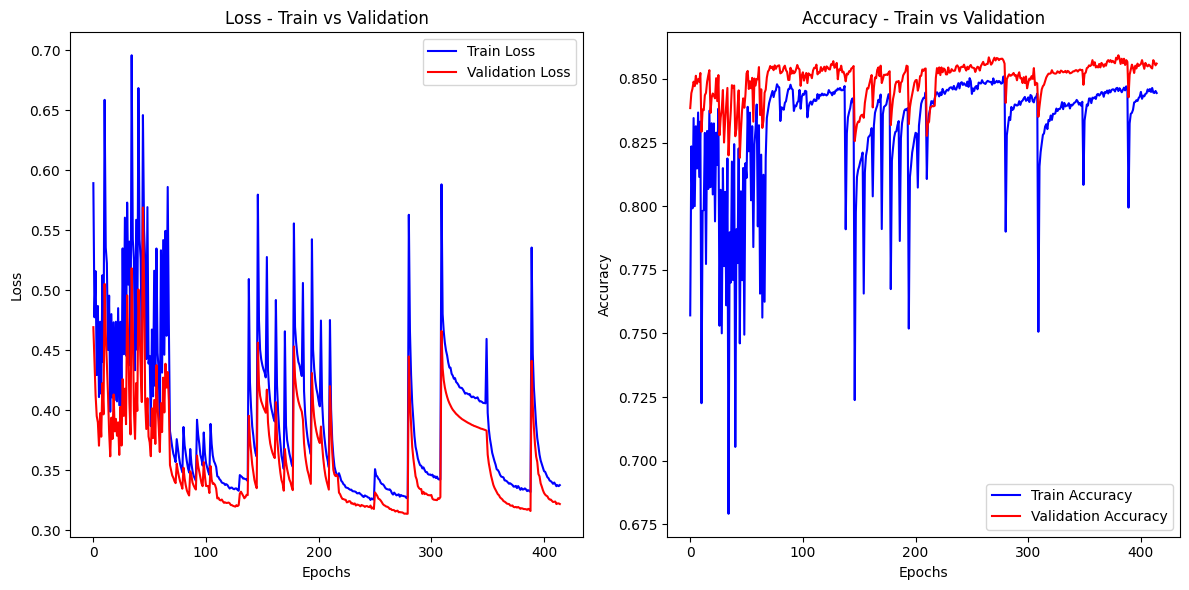

In [10]:
# WSZYSTKIE WYNIKI

# pobieranie wszystkich metryk z callbacka
train_losses = [metrics['train_loss'] for metrics in dnn_metrics]
train_accuracies = [metrics['train_accuracy'] for metrics in dnn_metrics]
val_losses = [metrics['val_loss'] for metrics in dnn_metrics]
val_accuracies = [metrics['val_accuracy'] for metrics in dnn_metrics]

plt.figure(figsize=(12, 6))

# wykres dla train loss i val loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Loss - Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# wykres dla train acc i val acc
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Accuracy - Train vs Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Mimo to wyykresy pokazują, że model DNN osiąga stabilne i wysokie wyniki na zbiorze walidacyjnym, mimo dość dużych wahań w metrykach treningowych, szczególnie na początku. Widoczne skoki w train loss i train accuracy mogą wynikać z dynamicznych zmian learning rate lub zastosowania mechanizmów restartu treningu. Z czasem jednak krzywe się uspokajają, a val loss i val accuracy pokazują dobrą generalizację i brak przeuczenia. Model ewidentnie dobrze radzi sobie na zbiorze walidacyjnym, mimo niestabilnego przebiegu treningu.

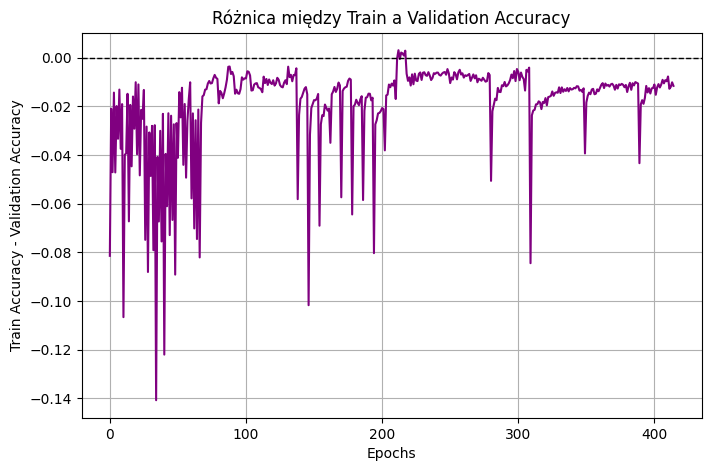

In [11]:
# różnica accuracy
accuracy_gap = [train - val for train, val in zip(train_accuracies, val_accuracies)]

plt.figure(figsize=(8, 5))
plt.plot(accuracy_gap, color="purple")
plt.title("Różnica między Train a Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy - Validation Accuracy")
plt.axhline(0, linestyle="--", color="black", linewidth=1)
plt.grid(True)
plt.show()

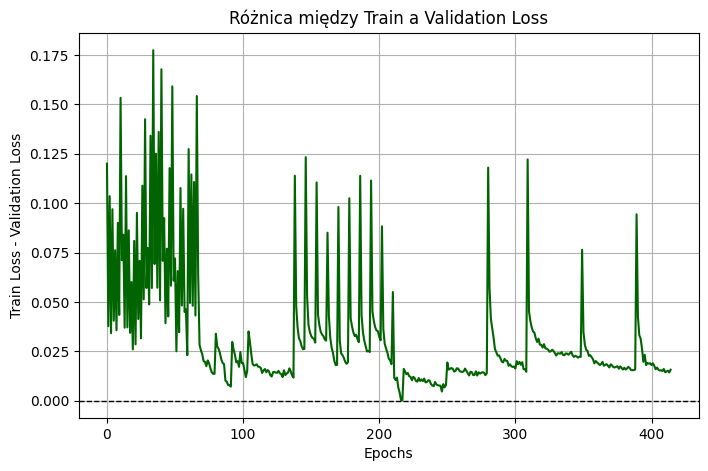

In [12]:
loss_gap = [train - val for train, val in zip(train_losses, val_losses)]

plt.figure(figsize=(8, 5))
plt.plot(loss_gap, color="darkgreen")
plt.title("Różnica między Train a Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss - Validation Loss")
plt.axhline(0, linestyle="--", color="black", linewidth=1)
plt.grid(True)
plt.show()

Oba wykresy potwierdzają, że model zachowuje dobrą ogólność i nie przeucza się. Na pierwszym wykresie wartości są przez większość czasu ujemne, co oznacza, że dokładność walidacyjna była wyższa niż treningowa.  

Na drugim wykresie widać, że train loss jest minimalnie większy niż val loss, co również potwierdza skuteczność regularyzacji. Wahania w pierwszych epokach są naturalne, później model stabilizuje się, a ogólne różnice są niewielkie, co świadczy o dobrze wytrenowanym i stabilnym modelu.

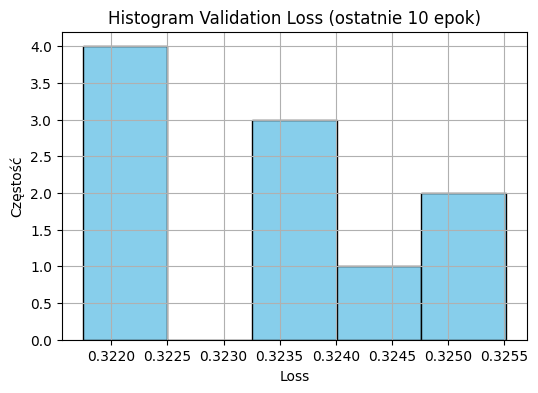

In [13]:
plt.figure(figsize=(6, 4))
plt.hist(val_losses[-10:], bins=5, color='skyblue', edgecolor='black')
plt.title("Histogram Validation Loss (ostatnie 10 epok)")
plt.xlabel("Loss")
plt.ylabel("Częstość")
plt.grid(True)
plt.show()

In [ ]:
# # odczyt z pliku
# with open("dnn/best_dnn_hyperparameters.pkl", "rb") as f:
#     best_dnn_hyperparameters = pickle.load(f)

Przeprowadzimy jeszcze dodatkową optymalizację modelu DNN poprzez porównanie działania różnych wartości batchsize. Dla każdej z testowanych wartości model trenujemy z tymi samymi hiperparametrami oraz harmonogramem uczenia.

In [14]:
batch_sizes = [16, 32, 64]
best_val_acc = 0
best_batch_size = None

for batch_size in batch_sizes:
    print(f"\nTrening dla batch_size = {batch_size}")

    fine_tuned_dnn = build_dnn(best_dnn_hyperparameters)

    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    checkpoint = ModelCheckpoint(f"dnn/DNN_opt_batch_{batch_size}.keras",
                                 save_best_only=True,
                                 monitor="val_accuracy",
                                 mode="max",
                                 verbose=1)

    lr_schedule = ExponentialDecay(1e-3, decay_steps=1000, decay_rate=0.96, staircase=True)
    fine_tuned_dnn.optimizer.learning_rate = lr_schedule

    history_2 = fine_tuned_dnn.fit(
        x_train_processed,
        y_train,
        epochs=100,  # więcej epok ale z early stopping
        validation_data=(x_val_processed, y_val),
        batch_size=batch_size,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    current_best_acc = max(history_2.history["val_accuracy"])

    # zaktualizowanie najlepszego batchsize
    if current_best_acc > best_val_acc:
        best_val_acc = current_best_acc
        best_batch_size = batch_size

fine_tuned_dnn.load_weights(f"dnn/DNN_opt_batch_{best_batch_size}.keras")

print(f"\nNajlepszy batch_size: {best_batch_size}")
print(f"Najlepsza walidacyjna dokładność: {best_val_acc:.5f}")


Trening dla batch_size = 16
Epoch 1/100
2121/2137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7975 - loss: 0.4763
Epoch 1: val_accuracy improved from -inf to 0.85081, saving model to dnn/DNN_opt_batch_16.keras
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.7976 - loss: 0.4760 - val_accuracy: 0.8508 - val_loss: 0.3634
Epoch 2/100
2134/2137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8268 - loss: 0.4004
Epoch 2: val_accuracy did not improve from 0.85081
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8268 - loss: 0.4004 - val_accuracy: 0.8505 - val_loss: 0.3498
Epoch 3/100
2134/2137 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8317 - loss: 0.3834
Epoch 3: val_accuracy did not improve from 0.85081
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8317 - loss: 0.3834 - val_accuracy: 0.8496 - val_loss: 0.3434
Epoch 4/100
2131/2137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8356 - loss: 0.3751
Epoch 4: val_accuracy improved from 0.85081 to 0.85149, sa

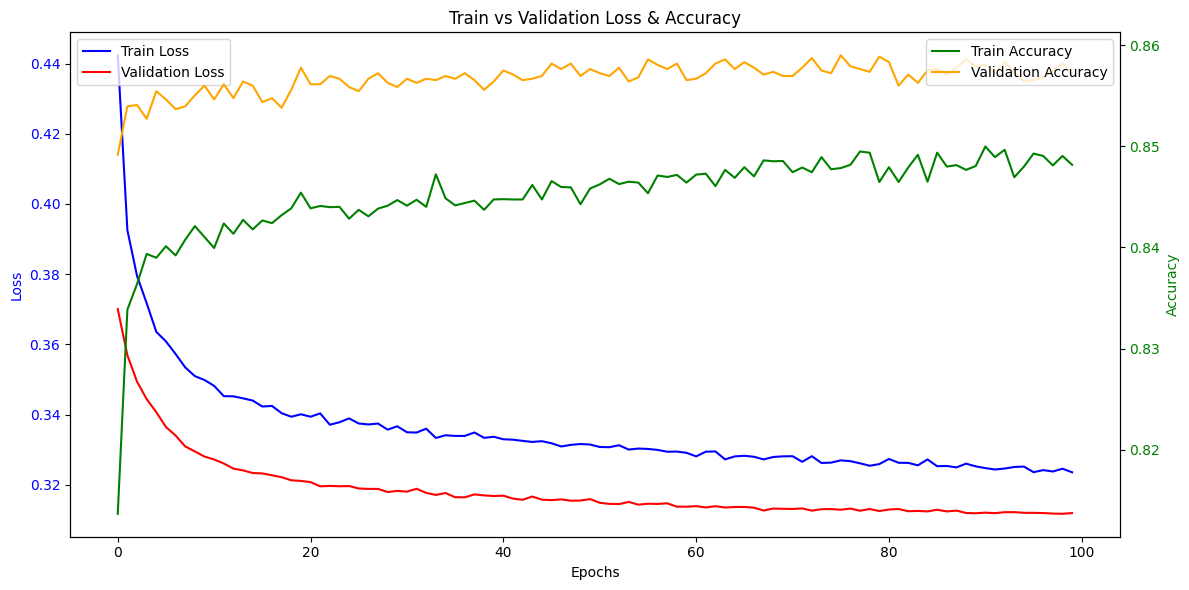

In [16]:
train_losses = history_2.history['loss']
val_losses = history_2.history['val_loss']
train_accuracies = history_2.history['accuracy']
val_accuracies = history_2.history['val_accuracy']

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Train vs Validation Loss & Accuracy')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(train_accuracies, label='Train Accuracy', color='green')
ax2.plot(val_accuracies, label='Validation Accuracy', color='orange')
ax2.set_ylabel('Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Wyniki przedstawione na wykresie pokazują bardzo dobrą stabilność modelu po dalszej optymalizacji, w tym doborze odpowiedniego batchsize. Krzywe strat dla zbioru treningowego i walidacyjnego systematycznie maleją, bez oznak przeuczenia. Zastosowany batchsize i harmonogram uczenia okazały się trafne i pozwoliły uzyskać stabilny, skuteczny model.

In [17]:
# fine_tuned_dnn.save("modele/fine_tuned_dnn.keras")

Model: DNN_opt_batch_16.keras
  Validation Loss: 0.32120
  Validation Accuracy: 0.85886
------------------------------
Model: DNN_opt_batch_32.keras
  Validation Loss: 0.31476
  Validation Accuracy: 0.85845
------------------------------
Model: DNN_opt_batch_64.keras
  Validation Loss: 0.31287
  Validation Accuracy: 0.85900
------------------------------


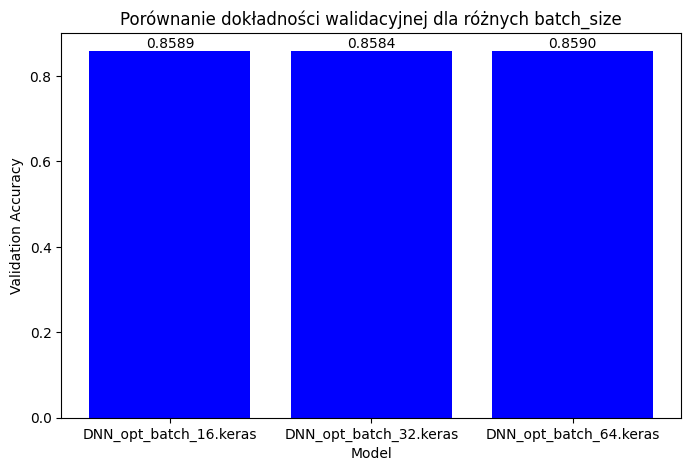

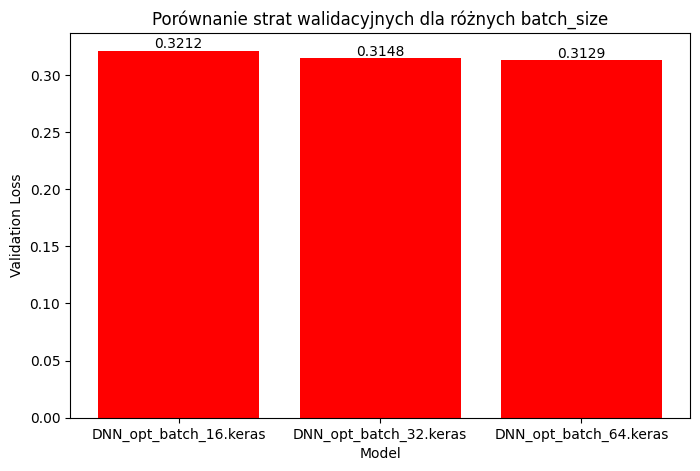

In [21]:
model_paths = [
    "dnn/DNN_opt_batch_16.keras",
    "dnn/DNN_opt_batch_32.keras",
    "dnn/DNN_opt_batch_64.keras"
]

evaluation_results = []

for model_path in model_paths:
    model = load_model(model_path)

    val_loss, val_accuracy = model.evaluate(x_val_processed, y_val, verbose=0)

    evaluation_results.append({
        'model': model_path.split('/')[-1],
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    })

for result in evaluation_results:
    print(f"Model: {result['model']}")
    print(f"  Validation Loss: {result['val_loss']:.5f}")
    print(f"  Validation Accuracy: {result['val_accuracy']:.5f}")
    print("-" * 30)

val_accuracies = [result['val_accuracy'] for result in evaluation_results]
model_names = [result['model'] for result in evaluation_results]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, val_accuracies, color='blue')
plt.title('Porównanie dokładności walidacyjnej dla różnych batch_size')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.show()

val_losses = [result['val_loss'] for result in evaluation_results]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, val_losses, color='red')
plt.title('Porównanie strat walidacyjnych dla różnych batch_size')
plt.xlabel('Model')
plt.ylabel('Validation Loss')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.show()

In [24]:
# fine_tuned_dnn = load_model("modele/fine_tuned_dnn.keras")

Dokonamy jeszcze końcowego dostrojenia modelu z bardzo małym learning rate. Celem tego etapu jest delikatne dopracowanie wag już dobrze wytrenowanego modelu, bez ryzyka pogorszenia jego działania. Sprawdzimy, czy dzięki niskiemu współczynnikowi uczenia, model może osiągnąć jeszcze lepsze dopasowanie i wyższą dokładność walidacyjną.

Epoch 1/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8491 - loss: 0.3245 - val_accuracy: 0.8576 - val_loss: 0.3126
Epoch 2/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8511 - loss: 0.3235 - val_accuracy: 0.8572 - val_loss: 0.3126
Epoch 3/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8488 - loss: 0.3251 - val_accuracy: 0.8578 - val_loss: 0.3126
Epoch 4/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8497 - loss: 0.3242 - val_accuracy: 0.8574 - val_loss: 0.3125
Epoch 5/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8497 - loss: 0.3232 - val_accuracy: 0.8571 - val_loss: 0.3125
Epoch 6/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8503 - loss: 0.3240 - val_accuracy: 0.8567 - val_loss: 0.3126
Epoch 7/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8506 - loss: 0.3245 - val_accuracy: 0.8565 - val_loss: 0.3125
Epoch 8/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8485 - loss: 0.3244 - val_accu

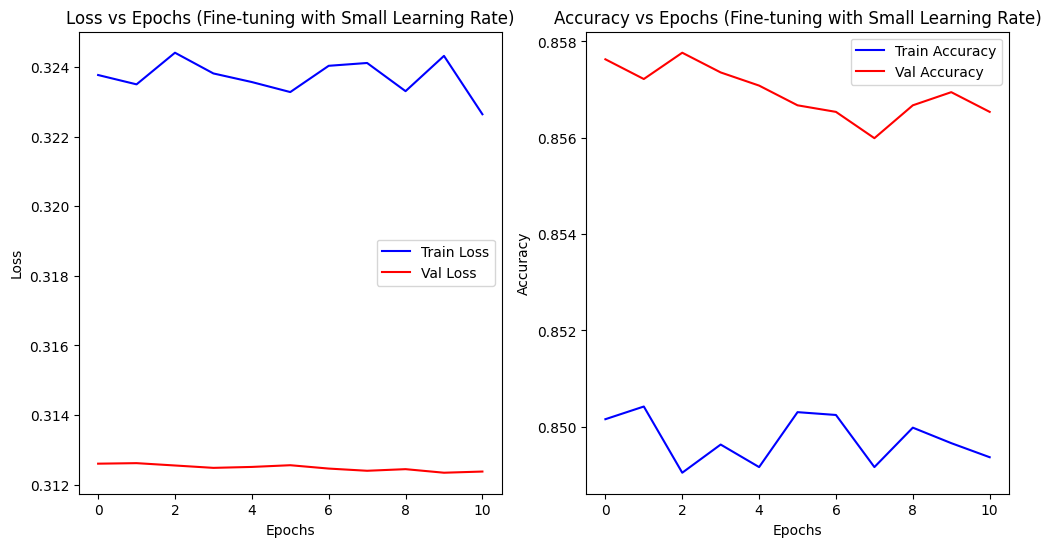

In [25]:
new_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

fine_tuned_dnn.compile(optimizer=new_optimizer, loss="binary_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, min_delta=0.001)
checkpoint = ModelCheckpoint("dnn/fine_tuned_model_lr_small.keras", save_best_only=True, monitor="val_accuracy", mode="max")

x_train_processed = preprocessor.fit_transform(x_train)
x_val_processed = preprocessor.transform(x_val)

history_fine_tune = fine_tuned_dnn.fit(
    x_train_processed,
    y_train,
    epochs=100,
    validation_data=(x_val_processed, y_val),
    batch_size=64,  # najlepszy batchsize
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_fine_tune.history['loss'], label='Train Loss', color='blue')
plt.plot(history_fine_tune.history['val_loss'], label='Val Loss', color='red')
plt.title('Loss vs Epochs (Fine-tuning with Small Learning Rate)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fine_tune.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_fine_tune.history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Accuracy vs Epochs (Fine-tuning with Small Learning Rate)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Jak widać, ze względu na brak poprawy val loss, model zatrzymał się na 11 epoce. Widzimy, że zarówno train loss, jak i val loss utrzymywały się na bardzo niskim, stabilnym poziomie. Również dokładność walidacyjna pozostała wysoka i nieco przewyższała dokładność treningową, co świadczy o dobrej generalizacji modelu.  

Fine-tuning z małym learning rate nie doprowadził do dużych zmian, ale pozwolił delikatnie poprawić parametry bez ryzyka pogorszenia jakości, co było właśnie celem tego etapu.

In [26]:
# fine_tuned_dnn.save("modele/best_DNN.keras")

# Porównanie wyników modeli po optymalizacji

In [56]:
folder_path = "final_models/"

model_types = {
    "RandomForest": "pkl", "SVM": "pkl", "XGBoost": "pkl",
    "ANN": "keras", "DNN": "keras",
    "best_RandomForest": "pkl", "best_SVM": "pkl", "best_XGBoost": "pkl",
    "best_ANN": "keras", "best_DNN": "keras"
}

models = {}
best_models = {}

for model_name, file_type in model_types.items():
    file_path = os.path.join(folder_path, f"{model_name}.{file_type}")

    if not os.path.exists(file_path):
        continue

    if file_type == "keras":
        model = load_model(file_path)
    else:
        model = joblib.load(file_path)

    if "best_" in model_name:
        base_name = model_name.replace("best_", "")
        best_models[base_name] = model
    else:
        models[model_name] = model

    print(f"Model {model_name} wczytany pomyślnie.")


Model RandomForest wczytany pomyślnie.
Model SVM wczytany pomyślnie.
Model XGBoost wczytany pomyślnie.
Model ANN wczytany pomyślnie.
Model DNN wczytany pomyślnie.
Model best_RandomForest wczytany pomyślnie.
Model best_SVM wczytany pomyślnie.
Model best_XGBoost wczytany pomyślnie.
Model best_ANN wczytany pomyślnie.
Model best_DNN wczytany pomyślnie.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [57]:
x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

# ccena modeli przed optymalizacją
pre_optimization_results = {}
pre_optimization_conf_matrices = {}

for model_name, model in models.items():
    if isinstance(model, tf.keras.Model):
        y_pred_prob = model.predict(x_test_processed).flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)

        loss = model.evaluate(x_test_processed, y_test, verbose=0)[0]
        accuracy = accuracy_score(y_test, y_pred)

    else:
        y_pred = model.predict(x_test)
        y_pred_prob = model.predict_proba(x_test)[:, 1] if hasattr(model, "predict_proba") else None
        loss = log_loss(y_test, y_pred_prob) if y_pred_prob is not None else None
        accuracy = accuracy_score(y_test, y_pred)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    pre_optimization_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC-AUC": roc_auc,
        "Loss": loss
    }

    pre_optimization_conf_matrices[model_name] = confusion_matrix(y_test, y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


  1/229 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [58]:
# ccena modeli po optymalizacji
post_optimization_results = {}
post_optimization_conf_matrices = {}

for model_name, model in best_models.items():
    if isinstance(model, tf.keras.Model):
        y_pred_prob = model.predict(x_test_processed).flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)

        loss = model.evaluate(x_test_processed, y_test, verbose=0)[0]
        accuracy = accuracy_score(y_test, y_pred)

    else:
        y_pred = model.predict(x_test)
        y_pred_prob = model.predict_proba(x_test)[:, 1] if hasattr(model, "predict_proba") else None
        loss = log_loss(y_test, y_pred_prob) if y_pred_prob is not None else None
        accuracy = accuracy_score(y_test, y_pred)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    post_optimization_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC-AUC": roc_auc,
        "Loss": loss
    }

    post_optimization_conf_matrices[model_name] = confusion_matrix(y_test, y_pred)

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [59]:
df_pre_optimization = pd.DataFrame(pre_optimization_results).T
print("\nPodsumowanie metryk testowych dla modeli przed optymalizacją:")
print(df_pre_optimization)

df_post_optimization = pd.DataFrame(post_optimization_results).T
print("\nPodsumowanie metryk testowych dla modeli po optymalizacji:")
print(df_post_optimization)


Podsumowanie metryk testowych dla modeli przed optymalizacją:
              Accuracy  Precision    Recall  F1 Score   ROC-AUC      Loss
RandomForest  0.780538   0.613459  0.223617  0.327759  0.588628  0.551197
SVM           0.760748   0.000000  0.000000  0.000000  0.500000  0.563349
XGBoost       0.777399   0.589443  0.229321  0.330185  0.621383  0.539142
ANN           0.848096   0.731548  0.576726  0.644976  0.902128  0.325875
DNN           0.853009   0.733103  0.606389  0.663753  0.904618  0.317649

Podsumowanie metryk testowych dla modeli po optymalizacji:
              Accuracy  Precision    Recall  F1 Score   ROC-AUC      Loss
RandomForest  0.864474   0.778184  0.606389  0.681629  0.914923  0.302932
SVM           0.849324   0.758566  0.543069  0.632979  0.887329  0.358225
XGBoost       0.874710   0.787337  0.652596  0.713662  0.928468  0.274891
ANN           0.850007   0.742942  0.570451  0.645369  0.899644  0.350422
DNN           0.853146   0.742652  0.590987  0.658196  0.904478

Końcowe wyniki wyraźnie pokazują, że optymalizacja przyniosła zauważalną poprawę dla wszystkich modeli. Szczególnie dobrze wypadły modele RandomForest i XGBoost, które po optymalizacji osiągnęły najwyższe wyniki we wszystkich kluczowych metrykach.

Modele ANN i DNN utrzymały dobrą skuteczność, ale ich poprawa była umiarkowana – głównie w zakresie precyzji i strat, natomiast F1 Score i Recall nie uległy dużym zmianom.
Wyniki SVM przed optymalizacją na zbiorze testowym są trochę szokujące - bo zerowe, co prawdopodobnie wynika z tego ze model w ogóle nie przewidział żadnej próbki jako pozytywnej. Mimo tego słabego wyniku, po dostrojeniu znacząco się poprawił, choć nadal wypada słabiej niż inne modele.

Podsumowując: mimo niewielkich zmian dla modeli neuronowych, proces optymalizacji można ogólnie uznać za skuteczny, a najlepsze wyniki końcowe uzyskano dla XGBoost i RandomForest, które wykazały najwyższą ogólną jakość klasyfikacji na zbiorze testowym.

# Macierze konfuzji dla modeli przed optymalizacją

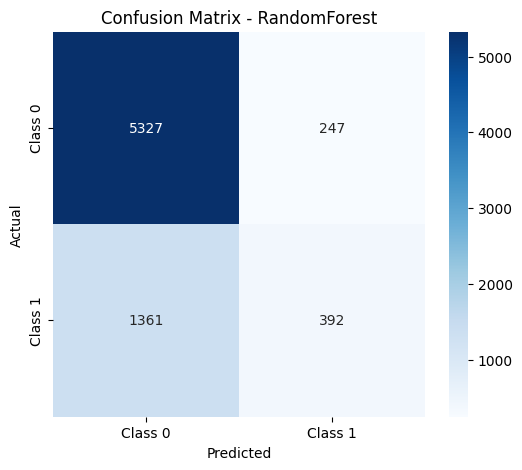

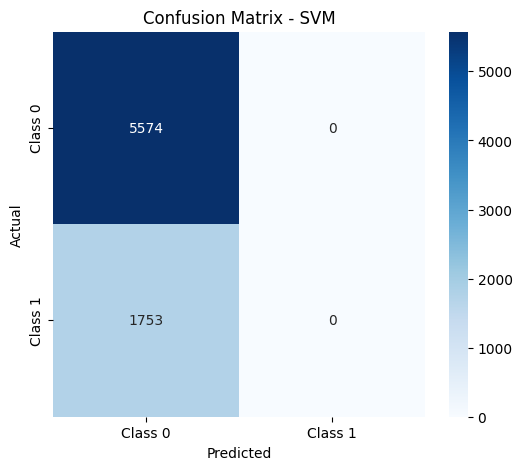

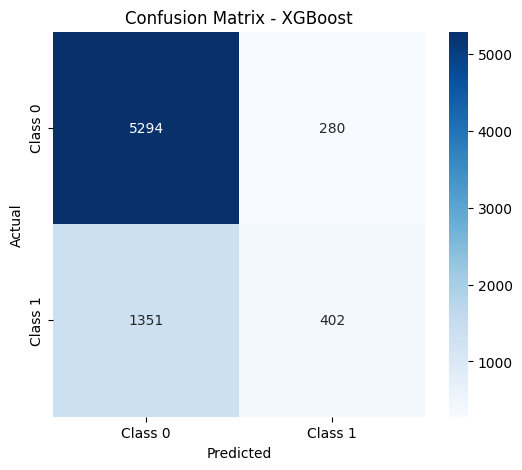

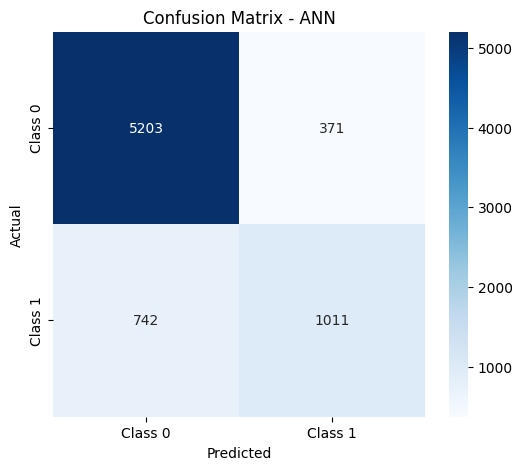

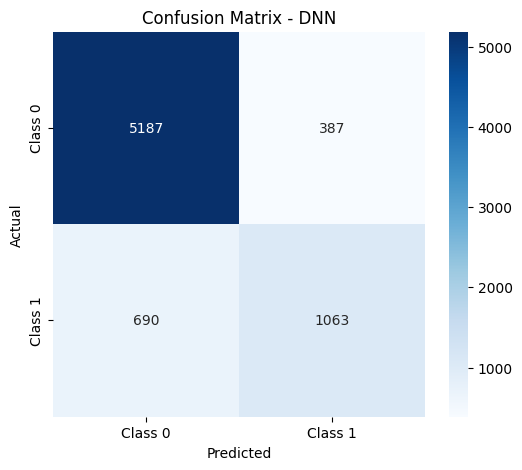

In [60]:
for model_name, conf_matrix in pre_optimization_conf_matrices.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Macierze konfuzji dla modeli po optymalizacji

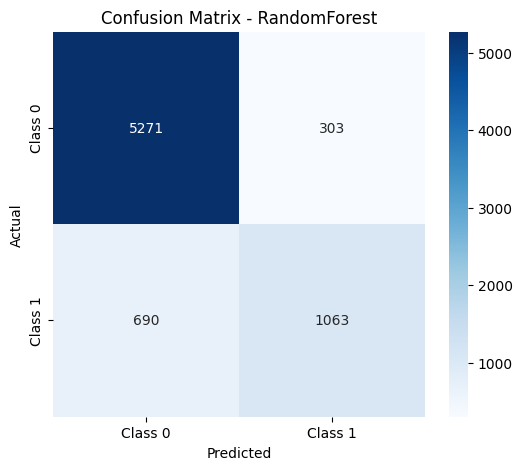

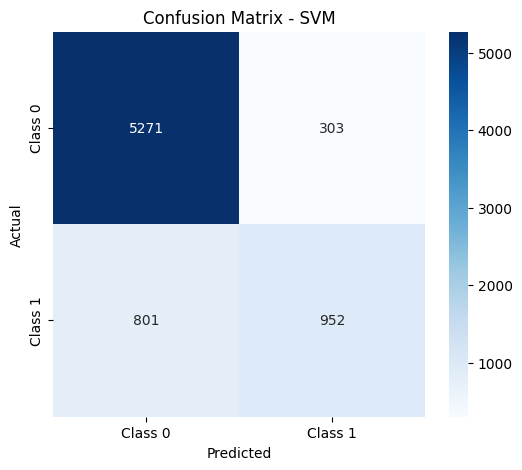

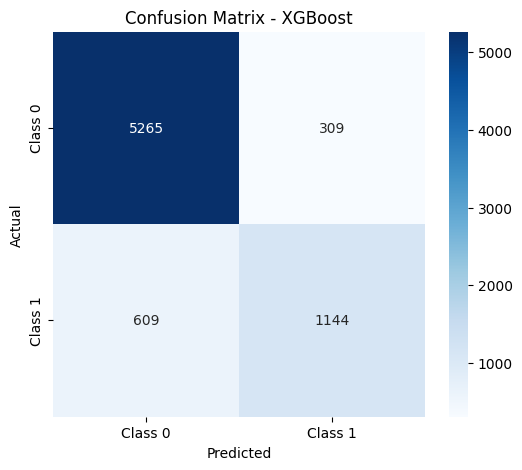

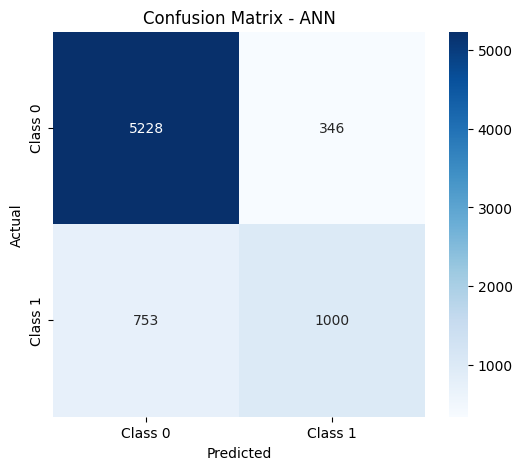

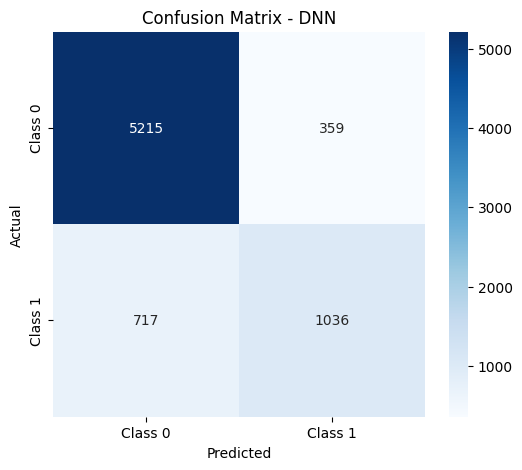

In [61]:
for model_name, conf_matrix in post_optimization_conf_matrices.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Wizualizacja końcowych wyników

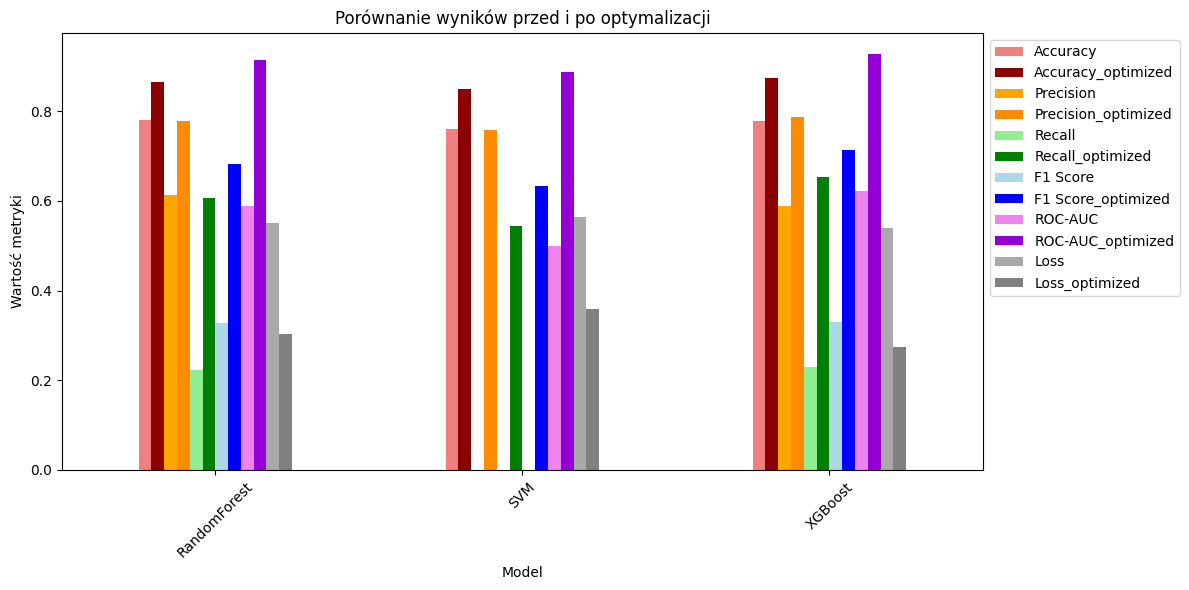

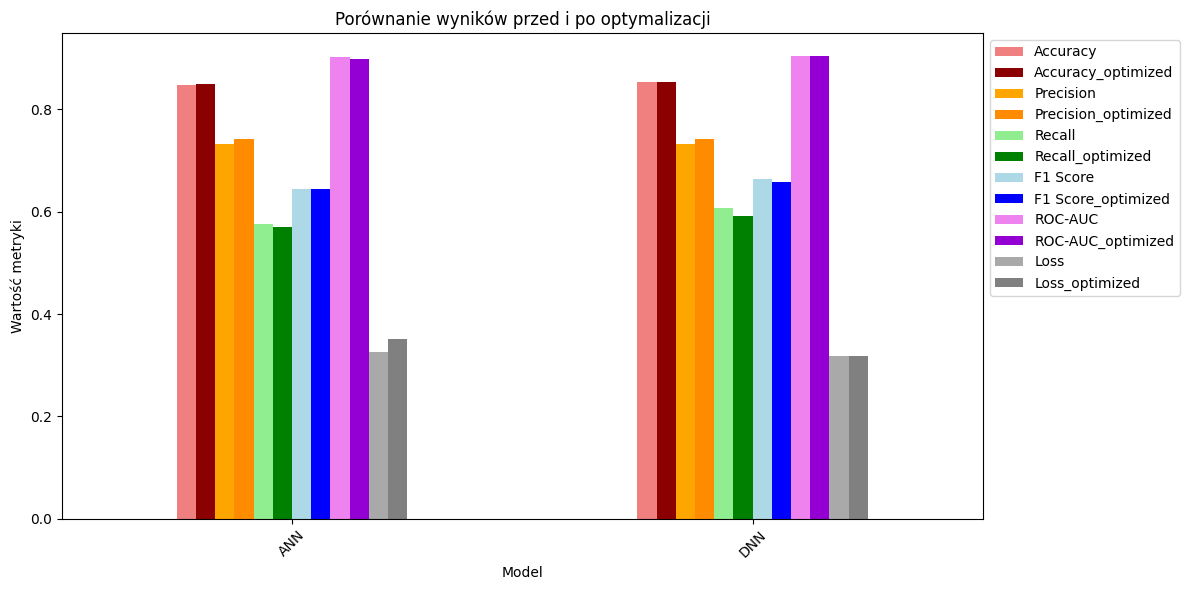

In [62]:
def plot_comparison_for_models(model_names, results_dict, optimized_results_dict, metrics):
    metric_colors = {
        "Accuracy": ["lightcoral", "darkred"],
        "Precision": ["orange", "darkorange"],
        "Recall": ["lightgreen", "green"],
        "F1 Score": ["lightblue", "blue"],
        "ROC-AUC": ["violet", "darkviolet"],
        "Loss": ["darkgray", "gray"]
    }

    before_after_data = {}

    for metric in metrics:
        before_after_data[metric] = [
            results_dict[model].get(metric, 0) for model in model_names
        ]
        before_after_data[metric + "_optimized"] = [
            optimized_results_dict[model].get(metric, 0) for model in model_names
        ]

    df_comparison = pd.DataFrame(before_after_data, index=model_names)

    colors = []

    for metric in df_comparison.columns:
        if "optimized" in metric:
            metric_name = metric.replace("_optimized", "")
            if metric_name in metric_colors:
                colors.append(metric_colors[metric_name][1])
        else:
            metric_name = metric
            if metric_name in metric_colors:
                colors.append(metric_colors[metric_name][0])

    ax = df_comparison.plot(kind='bar', figsize=(12, 6), color=colors)
    plt.title("Porównanie wyników przed i po optymalizacji")
    plt.ylabel("Wartość metryki")
    plt.xticks(rotation=45)
    plt.xlabel("Model")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()

    plt.show()

classical_models = ["RandomForest", "SVM", "XGBoost"]
ann_dnn_models = ["ANN", "DNN"]
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC", "Loss"]

plot_comparison_for_models(classical_models, pre_optimization_results, post_optimization_results, metrics)
plot_comparison_for_models(ann_dnn_models, pre_optimization_results, post_optimization_results, metrics)

# Podsumowanie

W trakcie pracy nad zadaniem cenną wartością była możliwość praktycznego porównania różnych modeli klasyfikacyjnych – zarówno klasycznych, jak i opartych na sieciach neuronowych oraz zastosowania technik ich optymalizacji. Uświadomiłam sobie, jak dużą różnicę mogą robić odpowiednio dobrane hiperparametry oraz jak ważne jest monitorowanie wyników nie tylko na zbiorze walidacyjnym, ale przede wszystkim na danych testowych, które pozwalają realnie ocenić zdolność modelu do generalizacji.

Zauważyłam również, że niezbalansowane dane mają istotny wpływ na metryki takie jak recall czy precision, co warto mieć na uwadze przy wyborze metryk optymalizacyjnych. 

Obszarem wymagającym dalszej pracy jest m.in. lepsze zbalansowanie zbioru danych, a także dokładniejsze zrozumienie, które metryki najlepiej odpowiadają na potrzeby konkretnego problemu.